In [1]:
import pandas as pd
import numpy as np
import itertools
from itertools import chain
import csv
import re
import nltk
from tqdm import tqdm
import random
from sklearn.model_selection import KFold
import time
import matplotlib.pyplot as plt
import datetime
from sentence_transformers import SentenceTransformer
import pickle
import os
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, BertConfig, BertForSequenceClassification, TrainingArguments, AutoModelForSequenceClassification, DataCollatorWithPadding, Trainer, AutoTokenizer, TFBertModel, BertModel
import torch
import torch.nn as nn
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from collections import Counter
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import classification_report
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from datasets import Dataset, DatasetDict
from evaluate import load
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\woute\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [15]:
def import_communication_data(path: str, preprocess:bool = True, remove_signoff:bool = True, newline:str = r'_/n_', reply_signs:list = None, code_words:list = None, remove_bots:bool = True, remove_names:bool = True, negation_preprocessing:bool = False, emoticon_preprocessing:bool = True, token_removal:bool = True) -> pd.DataFrame:
    print('Importing data...')
    raw_data = pd.read_csv(path, parse_dates=['reply_datetimetz']).dropna(axis = 0, subset = ['reply_from', 'reply_id', 'reply_subject', 'reply_body'])
    # Remove URLs
    raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$\-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', regex = True)

    if raw_data.dtypes['reply_datetimetz']=='object':
        raw_data['reply_datetimetz'] = pd.to_datetime(raw_data['reply_datetimetz'], format = 'mixed')
    raw_data.reply_datetimetz = raw_data.reply_datetimetz.dt.tz_localize(tz = 'UTC')

    regex_newline = newline.replace('/', r'\/')
    if not preprocess:
        raw_data['reply_body'] = raw_data['reply_body'].str.replace(regex_newline, ' ', regex = True)
        raw_data['reply_subject'] = raw_data['reply_subject'].str.replace(regex_newline, ' ', regex = True)
        raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'\s\s+', ' ', regex = True)
        return raw_data
        
    
    # raw_data['reply_body'] = raw_data['reply_body'].str.replace(newline+'.*\(\).*'+newline, regex = True) # remove most code, as we remove all sentences where brackets do not contain any information --> Tekst over code willen we erin houden
    tqdm.pandas()
    print('Removing replies...')
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('(?:'+regex_newline+'\s*)+>.*?(?='+regex_newline+')', '', regex = True) # remove all replies, signified with > before the start of a sentence
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('(?:'+regex_newline+r'\s*)+\|.*?(?='+regex_newline+')', '', regex = True) # remove all replies signified with | before the start of a sentence
    print('Removing Unnecessary code-like text...')
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('-----BEGIN PGP SIGNED MESSAGE-----', '')
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('----- GICM -----', '')
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('----- SERVER -----.*$', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('----- CLIENT -----.*$', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'-----+\s* logs follow -----.*$', '', regex = True)
    
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('-----cut here-----.*-----cut here-----', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('-----8<-----.*-----8<-----', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('-----BEGIN PGP SIGNATURE-----.*-----END PGP SIGNATURE-----', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'(?:^|'+regex_newline+r')((?:(?!'+regex_newline+r').)*?[Ww]rote:)', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('----- start patch -----.*----- end patch -----', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('----- start -----.*----- end -----', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('-----+Build Errors-----.*error[^'+regex_newline+']*'+regex_newline, newline, regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'([+\-]*-----\+-----[+\-]*)'+regex_newline +r'.*([+\-]*-----\+-----[+\-]*)', r'\2', regex = True)
    raw_data['reply_body'].str.replace(r'([+\-]*-----+-----[+\-]*)', r'', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('----- Forwarded [mM]essage -----.*----- End forwarded message -----', '', regex = True)
    
    
    if remove_signoff:
        print('Removing Sign-offs...')
        raw_data['reply_body'] = raw_data['reply_body'].str.replace(regex_newline+r'\s*-+[a-zA-Z ]*\s*'+regex_newline+r'[^\-]*-*([^\-]|(\d(-\d)+))*($|([Pp].[Ss].))', '\\4', regex = True)
    
    if reply_signs:
        print('Removing e-mail replies...')
        for reply in tqdm(reply_signs):
            raw_data['reply_body'] = raw_data['reply_body'].str.replace(reply+'.*$', '', regex = True)
            
    if code_words:
        print('Removing code words...')
        for word in tqdm(code_words):
            raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'\s' + word + r'\s', '', regex = True)
    
    if remove_bots:
        print('Removing bots from entries...')
        raw_data = raw_data[~raw_data['reply_from'].str.contains(r'[\(\[\-]bot(?:[\)\]]|$)', case = False)]
        
    if remove_names:
        print('Removing Names...')
        # In order:
        # Remove quotation marks
        # Remove stuff between brackets (vaak email adressen)
        # Remove Email adresses still left in name
        # Remove dots from the name
        # Remove things added to the end of a name after - (often company of employment) (require whitespaces to make sure second names are not affected)
        # Remove entries which contain an x with a set of numbers succeeding it, as this is likely introduced by a unknown character
        # Retrieve nickname, which is usually posted between two backslashes (\...\)
        # If there is only one character (often one letter left from 2nd name/abbreviation at the start of the name), remove it
        # Remove the extra space surrounding a | token
        # Remove additional white spaces at the start/end of a token
        # Remove multiple white spaces after each other
        # Remove test and test account from the set of names
        names = set(itertools.chain(*raw_data.reply_from.str.replace('"', '').str.replace("[<(].*[>)]", '', regex = True).str.replace(r"[a-zA-Z0-9.\-_]+@\w+(.\w\w+)+", '', regex = True).str.replace('.', '').str.replace(r'\s-\s\w+($|\|)', '', regex = True).str.replace(r'(^|\|)\s*(.*),\s*(.*)($|\|)', '\\1\\3 \\2', regex = True).str.replace(r'x\d+', '', regex = True).str.replace(r'(^|\|)([^|]*)\\([^\\]+)\\([^|]*)(\||$)', '\\1\\2 \\4|\\3\\5', regex = True).str.replace(r'(^|\s)[^\|](\s|$)', ' ', regex = True).str.replace(r'\s+\|\s+', '|', regex = True).str.strip().str.replace(r'\s\s+', ' ', regex = True).str.split('|').to_list())).difference({'Test', 'Test Account', 'test', 'test account'})
        
        first_names = {name.split(' ')[0] for name in names}
        
        for name in tqdm(names):
            raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'\s+'+name+r'\s+', '', regex = True, case = False)
            
        for name in tqdm(first_names):
            raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'\s+'+name+r'\s+', '', regex = True, case = False)
        
    with open("SentiCR/SentiCR/Contractions.txt","r") as contractions,\
     open("SentiCR/SentiCR/EmoticonLookupTable.txt","r") as emotable:
        contractions_reader=csv.reader(contractions, delimiter='\t')
        emoticon_reader=csv.reader(emotable,delimiter='\t')
    
        #Hash words from dictionary with their values
        contractions_dict = {rows[0]:rows[1] for rows in contractions_reader}
        emodict={rows[0]:rows[1] for rows in emoticon_reader}
    
        contractions.close()
        emotable.close()
        
    print('Removing contractions...')
    contractions_regex = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
    raw_data['reply_body'] = raw_data['reply_body'].progress_apply(lambda x: expand_contractions(x, contractions_dict, contractions_regex))
    
    if emoticon_preprocessing:
        print('Removing emoticons...')
        for emoticon in tqdm(emodict):
            raw_data['reply_body'] = raw_data['reply_body'].str.replace(emoticon, emodict[emoticon])
            
    if negation_preprocessing:
        print('Negating text...')
        raw_data['reply_body'] = raw_data['reply_body'].progress_apply(lambda x: handle_negation(x))
        
    
    print('Removing infrequent words...')

    # split words into lists
    v = raw_data['reply_body'].str.split().tolist() # [s.split() for s in df['Col2'].tolist()]
    # compute global word frequency
    c = Counter(chain.from_iterable(v))
    # filter, join, and re-assign
    raw_data['reply_body'] = [' '.join([j for j in i if c[j] > 5]) for i in v]
        
    raw_data['reply_body'] = raw_data['reply_body'].str.replace(regex_newline, ' ', regex = True)
    raw_data['reply_subject'] = raw_data['reply_subject'].str.replace(regex_newline, ' ', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'\s\s+', ' ', regex = True)
    return raw_data
    
   
def import_dev_data(path:str, communication_data:pd.DataFrame = None, model = None, tokenizer = None, LR:bool = False, bert_messages:pd.DataFrame = None) -> pd.DataFrame:
    tqdm.pandas()
    print('Importing dev data')
    data = pd.read_csv(path, parse_dates=['From','To'])
    
    dates = data.From.unique()
    data.set_index(['Alias', 'From'], inplace = True)
    data['Messages Sent'] = data['Messages Sent'].fillna(0)
    
    print('Calculating Seasonality...')
    monthly_average = data.groupby(data.index.get_level_values('From').month)['Workload'].mean()
    mapped_monthly_average = data.index.get_level_values('From').map(lambda x: monthly_average.loc[x.month])
    
    data['standardized_workload'] = data['Workload']/mapped_monthly_average
    
    
    data['burnout'] = np.nan
    print('Calculating burnout per dev...')
    for developer in tqdm(data.index.levels[0].unique()):
        data = calculate_burnout(developer, data)
       
    print('Calculating lagged burnouts...')
    data['lagged_burnout'] = data.groupby(level=0)['burnout'].shift(periods = -1)
    data['burnout_t+1'] = data.apply(lambda x: calculate_lagged_burnout(x), axis = 1)
    data['burnout_t+3'] = (data.groupby(level=0)['burnout'].shift(periods = -3)) | (data.groupby(level=0)['burnout'].shift(periods = -2)) | (data['burnout_t+1']) 
    data['burnout_t+12'] = (data.groupby(level=0)['burnout'].shift(periods = -12)) | (data.groupby(level=0)['burnout'].shift(periods = -11)) | (data.groupby(level=0)['burnout'].shift(periods = -10)) |(data.groupby(level=0)['burnout'].shift(periods = -9)) | (data.groupby(level=0)['burnout'].shift(periods = -8)) |(data.groupby(level=0)['burnout'].shift(periods = -7)) | (data.groupby(level=0)['burnout'].shift(periods = -6)) |(data.groupby(level=0)['burnout'].shift(periods = -5)) | (data.groupby(level=0)['burnout'].shift(periods = -4)) | (data['burnout_t+3']) 
    
    print('Calculating Black Cloud...')
    data['black_cloud'] = (data['Radio Silence']) & (data.groupby(level = 0)['Radio Silence'].shift(periods = 1))
    
    if communication_data is None:
        # If we have not provided any communication_data, we only need the dev data
        return data
    
    print('Calculating quitting months')
    data['working_months'] = True # Indicate which months originally are worked in
    retrieved_dates = pd.Series(data.index.get_level_values(1).rename('Temp')).set_axis(data.index)
    # Quit happens when there are 3 consecutive months in which no work is performed or after the final month of work (which is not equivalent to the final month in the df)
    data['quit'] = (((data.Workload.isna()) &
                     (((data.groupby(level=0)['Workload'].shift(periods = -1).isna()) & (data.groupby(level=0)['Workload'].shift(periods = -2).isna())) |
                      ((data.groupby(level=0)['Workload'].shift(periods = -1).isna()) & (data.groupby(level=0)['Workload'].shift(periods = 1).isna())) |
                      ((data.groupby(level=0)['Workload'].shift(periods = 1).isna()) & (data.groupby(level=0)['Workload'].shift(periods = 2))))) | 
                    ((data.groupby(level=0)['working_months'].shift(periods = -1).isna()) & (retrieved_dates < max(retrieved_dates))) | 
                    ((data.groupby(level=0)['Workload'].shift(periods = -1).isna()) & (data.groupby(level=0)['Workload'].shift(periods = -2).isna()) & (data.groupby(level=0)['Workload'].shift(periods = -3).isna())))
    
    data['first_quit_month'] = ((data['quit']) & (~data.Workload.isna()))
    
    print('Calculating ragequit...')
    if bert_messages is None:
        data['ragequit_t+1'] = data.progress_apply(lambda x: detect_ragequit(x, communication_data, model, tokenizer), axis = 1)
    else:
        data['ragequit_t+1'] = data.progress_apply(lambda x: detect_ragequit(x, bert_messages, model, tokenizer), axis = 1)
    print('Calculating lagged ragequits...')
    data['ragequit_t+3'] = (data.groupby(level=0)['ragequit_t+1'].shift(periods = -2)) | (data.groupby(level=0)['ragequit_t+1'].shift(periods = -1)) | (data['ragequit_t+1']) 
    data['ragequit_t+12'] = (data.groupby(level=0)['ragequit_t+1'].shift(periods = -11)) | (data.groupby(level=0)['ragequit_t+1'].shift(periods = -10)) | (data.groupby(level=0)['ragequit_t+1'].shift(periods = -9)) |(data.groupby(level=0)['ragequit_t+1'].shift(periods = -8)) | (data.groupby(level=0)['ragequit_t+1'].shift(periods = -7)) |(data.groupby(level=0)['ragequit_t+1'].shift(periods = -6)) | (data.groupby(level=0)['ragequit_t+1'].shift(periods = -5)) |(data.groupby(level=0)['ragequit_t+1'].shift(periods = -4)) | (data.groupby(level=0)['ragequit_t+1'].shift(periods = -3)) | (data['ragequit_t+3']) 
    
    if LR:
        return data
    
    print('Reformatting communication dates')
    communication_data['reply_datetimetz'] = pd.to_datetime(communication_data['reply_datetimetz'], utc = True)
    communication_data['start_month'] = communication_data.progress_apply(lambda x: return_closest_date(x, dates), axis = 1)
    return communication_data.merge(data, how = 'left', left_on= ['reply_from', 'start_month'], right_index = True)

def import_network_data(path:str, communication_data:pd.DataFrame, communication:bool = True):
    print('Retrieving and combining network data...')
    network_data = pd.read_csv(path, parse_dates = ['start_datetime', 'end_datetime'])
    if communication:
        return communication_data.merge(network_data, how = 'left', left_on = 'start_month', right_on = 'start_datetime')
    else:
        communication_data.reset_index(inplace = True)
        return communication_data.merge(network_data, how = 'left', left_on = 'From', right_on = 'start_datetime')
    
    
def calculate_burnout(developer: str, all_dev_data: pd.DataFrame, decrease_percentage:float = 0.2, range = 3):
    all_days = pd.date_range(
        min(all_dev_data[all_dev_data.index.get_level_values('Alias') == developer].index.get_level_values('From')), 
        max(all_dev_data[all_dev_data.index.get_level_values('Alias') == developer].index.get_level_values('From')), 
        freq='30d')
    res_lst = []
    min_date = min(all_dev_data[all_dev_data.index.get_level_values('Alias') == developer].index.get_level_values('From'))+datetime.timedelta(days = range*30)
    for date in all_days:
        try:
            # Use try-except loop to include dates where there is no workload
            if date < min_date:
                # Cannot check the previous month for burnout, nor calculate it following the given definition of burnout, return NaN
                is_burnt_out = np.nan
            elif date == min_date:
                # For the fourth month, we simply have to calculate whether the deviation holds
                burnout_data = all_dev_data[(all_dev_data.index.get_level_values('Alias') == developer) & (all_dev_data.index.get_level_values('From') < date)]
                # Calculating the deviation, If there are too little entries, return NaN
                if len(burnout_data) < (2/3)*range:
                    is_burnt_out = np.nan
                else:
                    is_burnt_out = all_dev_data.at[(developer, date), 'standardized_workload'] < burnout_data.standardized_workload.median() * (1-decrease_percentage)
            else:
                # We first have to retrieve the last of the previous months which were not burnt-out to find the baseline
                if False in res_lst:
                    no_burnout_month = len(res_lst) - 1 - res_lst[::-1].index(False)
                    burnout_data = all_dev_data[(all_dev_data.index.get_level_values('Alias') == developer) & (all_days[no_burnout_month] < all_dev_data.index.get_level_values('From'))& (all_dev_data.index.get_level_values('From') < all_days[no_burnout_month+range])]
                    # Calculating the deviation, If there are too little entries, return NaN
                    if len(burnout_data) < (2/3)*range:
                        is_burnt_out = np.nan
                    else:
                        is_burnt_out = all_dev_data.at[(developer, date), 'standardized_workload'] < burnout_data.standardized_workload.median() * (1-decrease_percentage)
                    
                else:
                    # We need to compare the workload level of this month to the first 3 in accordance with date == min_date
                    burnout_data = all_dev_data[(all_dev_data.index.get_level_values('Alias') == developer) & (all_dev_data.index.get_level_values('From') < min_date)]
                    # Calculating the deviation, If there are too little entries, return NaN
                    if len(burnout_data) < (2/3)*range:
                        is_burnt_out = np.nan
                    else:
                        is_burnt_out = all_dev_data.at[(developer, date), 'standardized_workload'] < burnout_data.standardized_workload.median() * (1-decrease_percentage)
        except:
            # Happens when there is no workload in a given month
            is_burnt_out = np.nan
                        
        res_lst.append(is_burnt_out)
            
    res_df = pd.DataFrame({'burnout':res_lst, 'extra':res_lst}, index = pd.MultiIndex.from_tuples(itertools.product([developer], all_days), names = ['Alias', 'From']))
    # Create the rows with the new months 
    all_dev_data = all_dev_data.merge(res_df[['extra']], how = 'outer', left_index = True, right_index=True).drop('extra', axis = 1)
    # Fill the burnout of the all_dev_data
    return all_dev_data.combine_first(res_df).drop('extra', axis = 1)

def calculate_lagged_burnout(data: pd.Series) -> bool:
    if np.isnan(data.burnout):
        return data.lagged_burnout
    elif np.isnan(data.lagged_burnout):
        return data.burnout
    else: 
        return data.burnout or data.lagged_burnout
        

def detect_ragequit(dev_data: pd.Series, communication_data: pd.DataFrame, model, tokenizer):
    if not dev_data.quit:
        # Can never be ragequit if dev hasn't quit
        return False
    elif dev_data.first_quit_month:
        # Dev will quit somewhere in this time period, therefore, we will need to retrieve the closest message to the end of the month to analyse
        last_date = dev_data.To
    else:
        # Not accurate if there is still communication months after the work has stopped, but feels like necessary evil to reduce calculation times and to refrain from having to go through the entire dataframe to search for the first_quit_month
        last_date = dev_data.name[1]
        
    
    dev_name = dev_data.name[0]
    try:
        dev_communication = communication_data[(communication_data.reply_from == dev_name) & (pd.to_datetime(communication_data.reply_datetimetz) < last_date)]
        last_message = dev_communication[dev_communication['reply_datetimetz'] == max(dev_communication.reply_datetimetz)].iloc[0]['reply_body']
        inputs = tokenizer(last_message, return_tensors = 'pt')
        softmax = torch.nn.functional.softmax(model(**inputs)['logits'], dim=-1)
        return softmax[0,2].item() > softmax[0,1].item() and softmax[0,2].item() > 0.15
    
    except:
        # If the developer has no messages (before the quitting date), the previous code would return an error, therefore, these developers do not rage quit, but rather silently quit
        return False
    
# def calculate_future_burnout_3(observation: pd.Series, data: pd.DataFrame) -> bool:
#     if 
        

def return_closest_date(reply: pd.Series, date_range: list):
    return date_range[pd.Series([reply.reply_datetimetz - date if (reply.reply_datetimetz - date) > datetime.timedelta(seconds = 0) else datetime.timedelta(days = 50) for date in date_range]).idxmin()]

def expand_contractions(s, contractions_dict, contractions_regex):
     def replace(match):
         return contractions_dict[match.group(0)]
     return contractions_regex.sub(replace, s.lower())

def handle_negation(comments):
    grammar= r"""
    NegP: {<VERB>?<ADV>+<VERB|ADJ>?<PRT|ADV><VERB>}
    {<VERB>?<ADV>+<VERB|ADJ>*<ADP|DET>?<ADJ>?<NOUN>?<ADV>?}
    
    """
    chunk_parser = nltk.RegexpParser(grammar)
    sentences = nltk.sent_tokenize(comments)
    modified_st=[]
    for st in sentences:
        allwords = nltk.word_tokenize(st)
        modified_words=[]
        if negated(allwords):
            part_of_speech = nltk.tag.pos_tag(allwords,tagset='universal')
            chunked = chunk_parser.parse(part_of_speech)
            #print("---------------------------")
            #print(st)
            for n in chunked:
                if isinstance(n, nltk.tree.Tree):
                    words = [pair[0] for pair in n.leaves()]
                    #print(words)

                    if n.label() == 'NegP' and negated(words):
                        for i, (word, pos) in enumerate(n.leaves()):
                            if (pos=="ADV" or pos=="ADJ" or pos=="VERB") and (word!="not"):
                                modified_words.append(prepend_not(word))
                            else:
                                modified_words.append(word)
                    else:
                         modified_words.extend(words)
                else:
                    modified_words.append(n[0])
            newst =' '.join(modified_words)
            #print(newst)
            modified_st.append(newst)
        else:
            modified_st.append(st)
    return ". ".join(modified_st)

def negated(input_words):
    """
    Determine if input contains negation words
    """
    negation_words =['not', 'never', 'none', 'nobody', 'nowhere', 'neither', 'barely', 'hardly',
                     'nothing', 'rarely', 'seldom', 'despite' ]

    emoticon_words=['PositiveSentiment','NegativeSentiment']

    neg_words = []
    neg_words.extend(negation_words)
    for word in neg_words:
        if word in input_words:
            return True
    return False

def prepend_not(word):
    negation_words =['not', 'never', 'none', 'nobody', 'nowhere', 'neither', 'barely', 'hardly',
                     'nothing', 'rarely', 'seldom', 'despite' ]

    emoticon_words=['PositiveSentiment','NegativeSentiment']
    if word in emoticon_words:
        return word
    elif word in negation_words:
        return word
    return "NOT_"+word



In [3]:
geronimo_emails = ['----- Mensaje Original -----',
 '----- Methods required by DeploymentManager -----',
 '----- Methods required to populate Property Editors -----',
 '----- Oorspronkelijk bericht -----',
 '----- Original Message -----',
'-----Email-----',
 '-----Mensagem original-----',
 '-----Mensaje original-----',
 '-----Oorspronkelijk bericht-----',
 '-----Original Email-----',
 '-----Original Message-----',
 '-----Ursprungliche Nachricht-----',
 '-----Ursprungligt meddelande-----',
 '-----UrsprÃ¼ngliche Nachricht-----',
 '----- Forwarded Message -----',
 '----- Forwarded message -----']

code_words = ['while', 'case', 'switch','def', 'abstract','byte','continue','native','private','synchronized',
 'if', 'do', 'include', 'each', 'than', 'finally', 'class', 'double', 'float', 'int','else','instanceof',
 'long', 'super', 'import', 'short', 'default', 'catch', 'try', 'new', 'final', 'extends', 'implements',
 'public', 'protected', 'static', 'this', 'return', 'char', 'const', 'break', 'boolean', 'bool', 'package',
 'byte', 'assert', 'raise', 'global', 'with', 'or', 'yield', 'in', 'out', 'except', 'and', 'enum', 'signed',
 'void', 'virtual', 'union', 'goto', 'var', 'function', 'require', 'print', 'echo', 'foreach', 'elseif', 'namespace',
 'delegate', 'event', 'override', 'struct', 'readonly', 'explicit', 'interface', 'get', 'set','elif','for',
 'throw','throws','lambda','endfor','endforeach','endif','endwhile','clone']

In [4]:
csv_path = "dev-sentiment/train_df_final.csv"
text_column = "Text"  # Change this if your column is named differently

# Output paths
output_txt = "train_corpus.txt"
tokenizer_dir = "custom-bert-tokenizer"
vocab_size = 28996  # MUST match the vocab size expected by your model

print("Reading CSV...")
df = pd.read_csv(csv_path)
df[text_column] = df[text_column].astype(str)
df[text_column].dropna().to_csv(output_txt, index=False, header=False)

print(f"Extracted {len(df)} lines of text to {output_txt}...")

# === Step 3: Train the Tokenizer ===

print("Training WordPiece tokenizer...")
tokenizer = BertWordPieceTokenizer(lowercase=True)

tokenizer.train(
    files=output_txt,
    vocab_size=vocab_size,
    min_frequency=2,
    limit_alphabet=1000,
    special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]
)

# Save the trained tokenizer
os.makedirs(tokenizer_dir, exist_ok=True)
tokenizer.save_model(tokenizer_dir)

# Save in Hugging Face format
hf_tokenizer = BertTokenizer.from_pretrained(tokenizer_dir)
hf_tokenizer.save_pretrained(tokenizer_dir)

print(f"Tokenizer saved to: {tokenizer_dir}")


Reading CSV...
Extracted 4068 lines of text to train_corpus.txt...
Training WordPiece tokenizer...
Tokenizer saved to: custom-bert-tokenizer


# Geronimo Analysis

In [5]:
project_name = 'geronimo'
start_year = 2003
end_year = 2007
tokenizer = BertTokenizer.from_pretrained("custom-bert-tokenizer")

# Set the vocab size to match the checkpoint
config = BertConfig.from_pretrained("bert-base-uncased", num_labels=3)
config.vocab_size = 28996  # important!

# Initialize the model with the updated config
model = BertForSequenceClassification(config)

# Load the checkpoint
state_dict = torch.load("dev-sentiment/bert_model.pt", map_location="cpu")
model.load_state_dict(state_dict)

# Ik moet wel nog steeds de NaNs in ragequit+3 en +12 vullen als +1 al True is

communication_test = import_communication_data("Test/data/"+project_name+"_communication_"+str(start_year)+"-"+str(end_year)+".csv", reply_signs=geronimo_emails, remove_names=True, negation_preprocessing=False, code_words=code_words)
dev_test = import_dev_data('Test/data/dev_data_'+project_name+'.csv', communication_test, model, tokenizer)
all_test = import_network_data('Test/data/network_data_'+project_name+'.csv', dev_test)

all_test

Importing data...
Removing replies...
Removing Unnecessary code-like text...
Removing Sign-offs...
Removing e-mail replies...


100%|██████████| 16/16 [00:00<00:00, 24.17it/s]


Removing code words...


100%|██████████| 88/88 [00:28<00:00,  3.06it/s]


Removing bots from entries...
Removing Names...


100%|██████████| 766/766 [07:28<00:00,  1.71it/s]


Removing contractions...


100%|██████████| 41693/41693 [00:04<00:00, 9677.83it/s] 


Removing emoticons...


100%|██████████| 96/96 [00:02<00:00, 36.80it/s]


Removing infrequent words...
Importing dev data
Calculating Seasonality...
Calculating burnout per dev...


100%|██████████| 44/44 [00:01<00:00, 36.69it/s]


Calculating lagged burnouts...
Calculating Black Cloud...
Calculating quitting months
Calculating ragequit...


100%|██████████| 1029/1029 [00:46<00:00, 22.28it/s]


Calculating lagged ragequits...
Reformatting communication dates


100%|██████████| 41693/41693 [00:49<00:00, 836.79it/s]


Retrieving and combining network data...


,identity_id,reply_from,reply_id,in_reply_to_id,reply_datetimetz,reply_to,reply_cc,reply_subject,reply_body,reply_tz,...,end_datetime,st_congruence,reply_degree,reply_close,reply_between,git_degree,git_close,git_between,reply_density,git_density
0,1,Geir Magnusson Jr <geirm@apache.org> | Geir Ma...,<43CC0458.3020803@pobox.com>,<43CBE61D.5070705@Golux.Com>,2006-01-16 20:38:48+00:00,dev@geronimo.apache.org,NaN,Re: -1 on checkin of 368344 was Re: [wadi-dev]...,i believe that most apache projects are funda...,-0500,...,2006-01-22 20:27:26+00:00,0.354839,0.389039,NaN,0.081224,0.584559,NaN,0.493924,0.154170,0.227941
1,1,Geir Magnusson Jr <geirm@apache.org> | Geir Ma...,<44E0D131.7090004@pobox.com>,<44E0BD85.9080504@hogstrom.org>,2006-08-14 19:38:25+00:00,dev@geronimo.apache.org,NaN,Re: [WELCOME] Please welcome alan Cabrera as t...,,-0400,...,2006-08-20 20:27:26+00:00,0.592593,0.354451,NaN,0.089655,0.352941,NaN,0.246107,0.167288,0.176471
2,1,Geir Magnusson Jr <geirm@apache.org> | Geir Ma...,<43E3DEEF.2030506@pobox.com>,<43E37150.6090509@Golux.Com>,2006-02-03 22:53:35+00:00,dev@geronimo.apache.org,NaN,Re: [VOTE] accept donation of a business proce...,i do not think you need much to believe that ...,-0500,...,2006-02-21 20:27:26+00:00,0.592593,0.418052,NaN,0.083791,0.350000,0.452999,0.205795,0.159268,0.450000
3,1,Geir Magnusson Jr <geirm@apache.org> | Geir Ma...,<43BBCFA5.5090009@pobox.com>,<1b5bfeb50601040500j5c5ec33ck@mail.gmail.com>,2006-01-04 13:37:41+00:00,dev@geronimo.apache.org,NaN,Re: javamail InternetAddress parsing.,i was dead serious PositiveSentiment right no...,-0500,...,2006-01-22 20:27:26+00:00,0.354839,0.389039,NaN,0.081224,0.584559,NaN,0.493924,0.154170,0.227941
4,1,Geir Magnusson Jr <geirm@apache.org> | Geir Ma...,<444912EC.60109@pobox.com>,<4447F2D0.8020609@hogstrom.org>,2006-04-21 17:14:20+00:00,dev@geronimo.apache.org,NaN,Re: [VOTE] 1.1 Code Freeze to start Monday 060...,i agreeaaron about being flexible about ship at,-0400,...,2006-04-22 20:27:26+00:00,0.275000,0.385368,NaN,0.105399,0.237179,0.311912,0.220118,0.107590,0.512821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41688,1167,JAR <joseantonioribeiro@gmail.com>,<14151744.post@talk.nabble.com>,NaN,2007-12-04 14:33:02+00:00,dev@geronimo.apache.org,NaN,Geronimo not ready for Application Server ADF ...,i have a simple project that call a jsp forma...,-0800,...,2007-12-13 20:27:26+00:00,0.285714,0.342625,NaN,0.048921,0.376190,NaN,0.131083,0.364692,0.266667
41689,1168,"RiaÃ±o Calvo, IvÃ¡n <iriano@indra.es> | ivanr...",<14434684.post@talk.nabble.com>,NaN,2007-12-20 11:33:06+00:00,dev@geronimo.apache.org,NaN,J2EE application client in geronimo 2.0.2,can i deploy j2ee 5 application there is no th...,-0800,...,2007-12-13 20:27:26+00:00,0.285714,0.342625,NaN,0.048921,0.376190,NaN,0.131083,0.364692,0.266667
41690,1168,"RiaÃ±o Calvo, IvÃ¡n <iriano@indra.es> | ivanr...",<14439820.post@talk.nabble.com>,<c278ac970712200742w60c208d1t6e783085125887b@m...,2007-12-20 16:24:21+00:00,dev@geronimo.apache.org,NaN,Re: J2EE application client in geronimo 2.0.2,"has created application deployment when it, i ...",-0800,...,2007-12-13 20:27:26+00:00,0.285714,0.342625,NaN,0.048921,0.376190,NaN,0.131083,0.364692,0.266667
41691,1168,"RiaÃ±o Calvo, IvÃ¡n <iriano@indra.es> | ivanr...",<25B180C9C4D3D54CA2F28BF7120C0FC001F2565E@MADS...,NaN,2007-12-20 08:10:05+00:00,<dev@geronimo.apache.org>,NaN,Documentation about how to deploy J2EE Aplicat...,necessary add to documentation an example abou...,+0100,...,2007-12-13 20:27:26+00:00,0.285714,0.342625,NaN,0.048921,0.376190,NaN,0.131083,0.364692,0.266667


In [6]:
all_test[['burnout', 'burnout_t+1', 'burnout_t+3', 'burnout_t+12', 'ragequit_t+1', 'ragequit_t+3', 'ragequit_t+12']].mean()

burnout          0.282074
burnout_t+1      0.489477
burnout_t+3      0.307878
burnout_t+12     0.393777
ragequit_t+1     0.018389
ragequit_t+3     0.033537
ragequit_t+12    0.148955
dtype: object

In [7]:
all_test.to_csv('Test/data/'+project_name+'_all_message_data.csv')

In [5]:
all_test = pd.read_csv('Test/data/geronimo_all_message_data.csv', parse_dates = ['reply_datetimetz', 'start_month', 'To', 'start_datetime', 'end_datetime']).drop('Unnamed: 0', axis = 1)
all_test

C:\Users\woute\AppData\Local\Temp\ipykernel_11104\1730089382.py:1: DtypeWarning: Columns (14,16,17,20,22,23,24,25,26,27,28,29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  all_test = pd.read_csv('Test/data/geronimo_all_message_data.csv', parse_dates = ['reply_datetimetz', 'start_month', 'To', 'start_datetime', 'end_datetime']).drop('Unnamed: 0', axis = 1)


,identity_id,reply_from,reply_id,in_reply_to_id,reply_datetimetz,reply_to,reply_cc,reply_subject,reply_body,reply_tz,...,end_datetime,st_congruence,reply_degree,reply_close,reply_between,git_degree,git_close,git_between,reply_density,git_density
0,1,Geir Magnusson Jr <geirm@apache.org> | Geir Ma...,<43CC0458.3020803@pobox.com>,<43CBE61D.5070705@Golux.Com>,2006-01-16 20:38:48+00:00,dev@geronimo.apache.org,NaN,Re: -1 on checkin of 368344 was Re: [wadi-dev]...,i believe that most apache projects are funda...,-0500,...,2006-01-22 20:27:26+00:00,0.354839,0.389039,NaN,0.081224,0.584559,NaN,0.493924,0.154170,0.227941
1,1,Geir Magnusson Jr <geirm@apache.org> | Geir Ma...,<44E0D131.7090004@pobox.com>,<44E0BD85.9080504@hogstrom.org>,2006-08-14 19:38:25+00:00,dev@geronimo.apache.org,NaN,Re: [WELCOME] Please welcome alan Cabrera as t...,NaN,-0400,...,2006-08-20 20:27:26+00:00,0.592593,0.354451,NaN,0.089655,0.352941,NaN,0.246107,0.167288,0.176471
2,1,Geir Magnusson Jr <geirm@apache.org> | Geir Ma...,<43E3DEEF.2030506@pobox.com>,<43E37150.6090509@Golux.Com>,2006-02-03 22:53:35+00:00,dev@geronimo.apache.org,NaN,Re: [VOTE] accept donation of a business proce...,i do not think you need much to believe that ...,-0500,...,2006-02-21 20:27:26+00:00,0.592593,0.418052,NaN,0.083791,0.350000,0.452999,0.205795,0.159268,0.450000
3,1,Geir Magnusson Jr <geirm@apache.org> | Geir Ma...,<43BBCFA5.5090009@pobox.com>,<1b5bfeb50601040500j5c5ec33ck@mail.gmail.com>,2006-01-04 13:37:41+00:00,dev@geronimo.apache.org,NaN,Re: javamail InternetAddress parsing.,i was dead serious PositiveSentiment right no...,-0500,...,2006-01-22 20:27:26+00:00,0.354839,0.389039,NaN,0.081224,0.584559,NaN,0.493924,0.154170,0.227941
4,1,Geir Magnusson Jr <geirm@apache.org> | Geir Ma...,<444912EC.60109@pobox.com>,<4447F2D0.8020609@hogstrom.org>,2006-04-21 17:14:20+00:00,dev@geronimo.apache.org,NaN,Re: [VOTE] 1.1 Code Freeze to start Monday 060...,i agreeaaron about being flexible about ship at,-0400,...,2006-04-22 20:27:26+00:00,0.275000,0.385368,NaN,0.105399,0.237179,0.311912,0.220118,0.107590,0.512821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41688,1167,JAR <joseantonioribeiro@gmail.com>,<14151744.post@talk.nabble.com>,NaN,2007-12-04 14:33:02+00:00,dev@geronimo.apache.org,NaN,Geronimo not ready for Application Server ADF ...,i have a simple project that call a jsp forma...,-0800,...,2007-12-13 20:27:26+00:00,0.285714,0.342625,NaN,0.048921,0.376190,NaN,0.131083,0.364692,0.266667
41689,1168,"RiaÃ±o Calvo, IvÃ¡n <iriano@indra.es> | ivanr...",<14434684.post@talk.nabble.com>,NaN,2007-12-20 11:33:06+00:00,dev@geronimo.apache.org,NaN,J2EE application client in geronimo 2.0.2,can i deploy j2ee 5 application there is no th...,-0800,...,2007-12-13 20:27:26+00:00,0.285714,0.342625,NaN,0.048921,0.376190,NaN,0.131083,0.364692,0.266667
41690,1168,"RiaÃ±o Calvo, IvÃ¡n <iriano@indra.es> | ivanr...",<14439820.post@talk.nabble.com>,<c278ac970712200742w60c208d1t6e783085125887b@m...,2007-12-20 16:24:21+00:00,dev@geronimo.apache.org,NaN,Re: J2EE application client in geronimo 2.0.2,"has created application deployment when it, i ...",-0800,...,2007-12-13 20:27:26+00:00,0.285714,0.342625,NaN,0.048921,0.376190,NaN,0.131083,0.364692,0.266667
41691,1168,"RiaÃ±o Calvo, IvÃ¡n <iriano@indra.es> | ivanr...",<25B180C9C4D3D54CA2F28BF7120C0FC001F2565E@MADS...,NaN,2007-12-20 08:10:05+00:00,<dev@geronimo.apache.org>,NaN,Documentation about how to deploy J2EE Aplicat...,necessary add to documentation an example abou...,+0100,...,2007-12-13 20:27:26+00:00,0.285714,0.342625,NaN,0.048921,0.376190,NaN,0.131083,0.364692,0.266667


In [9]:
dev_data = import_dev_data('Test/data/dev_data_'+project_name+'.csv', communication_test, model, tokenizer, LR = True)
logistic_data = import_network_data('Test/data/network_data_'+project_name+'.csv', dev_data, communication=False).dropna(axis = 0, subset = ['Radio Silence', 'Organisational Silo', 'Lone Wolf'])
logistic_data.to_csv('Test/data/'+project_name+'_logistic_data.csv')
logistic_data

Importing dev data
Calculating Seasonality...
Calculating burnout per dev...


100%|██████████| 44/44 [00:01<00:00, 38.96it/s]


Calculating lagged burnouts...
Calculating Black Cloud...
Calculating quitting months
Calculating ragequit...


100%|██████████| 1029/1029 [00:44<00:00, 22.97it/s]


Calculating lagged ragequits...
Retrieving and combining network data...


,Alias,From,Avg. distance,Lone Wolf,Messages Sent,Organisational Silo,Radio Silence,To,Workload,burnout,...,end_datetime,st_congruence,reply_degree,reply_close,reply_between,git_degree,git_close,git_between,reply_density,git_density
0,Aaron Mulder <ammulder@apache.org> | Aaron Mul...,2003-09-05 20:27:26+00:00,2.000000,True,64.0,True,False,2003-10-05 20:27:26+00:00,4537.0,NaN,...,2003-10-05 20:27:26+00:00,0.600000,0.310623,NaN,0.086449,0.321429,0.442635,0.174603,0.073993,0.535714
1,Aaron Mulder <ammulder@apache.org> | Aaron Mul...,2003-10-05 20:27:26+00:00,1.000000,False,35.0,False,True,2003-11-04 20:27:26+00:00,4323.0,NaN,...,2003-11-04 20:27:26+00:00,0.571429,0.288854,NaN,0.145026,0.321429,NaN,0.183673,0.152172,0.250000
2,Aaron Mulder <ammulder@apache.org> | Aaron Mul...,2003-11-04 20:27:26+00:00,2.200000,True,21.0,False,False,2003-12-04 20:27:26+00:00,2709.0,NaN,...,2003-12-04 20:27:26+00:00,0.500000,0.296677,NaN,0.054947,0.285714,0.489352,0.299320,0.072255,0.714286
5,Aaron Mulder <ammulder@apache.org> | Aaron Mul...,2004-02-02 20:27:26+00:00,3.000000,True,10.0,False,False,2004-03-03 20:27:26+00:00,614.0,True,...,2004-03-03 20:27:26+00:00,0.333333,0.402516,NaN,0.145110,0.355556,0.494880,0.191358,0.088050,0.533333
13,Aaron Mulder <ammulder@apache.org> | Aaron Mul...,2004-09-29 20:27:26+00:00,1.555556,True,124.0,True,True,2004-10-29 20:27:26+00:00,14785.0,False,...,2004-10-29 20:27:26+00:00,0.525000,0.374411,NaN,0.156966,0.212121,NaN,0.152066,0.107071,0.606061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1024,Vamsavardhana Chillakuru <vamsic007@apache.org>,2007-08-15 20:27:26+00:00,NaN,False,0.0,False,False,2007-09-14 20:27:26+00:00,24.0,True,...,2007-09-14 20:27:26+00:00,0.315789,0.352189,NaN,0.081888,0.441667,NaN,0.284444,0.240404,0.158333
1025,Vamsavardhana Chillakuru <vamsic007@apache.org>,2007-09-14 20:27:26+00:00,NaN,True,0.0,True,False,2007-10-14 20:27:26+00:00,757.0,False,...,2007-10-14 20:27:26+00:00,0.161290,0.485990,NaN,0.125215,0.347619,NaN,0.198980,0.225121,0.295238
1026,Vamsavardhana Chillakuru <vamsic007@apache.org>,2007-10-14 20:27:26+00:00,NaN,True,0.0,True,False,2007-11-13 20:27:26+00:00,10808.0,NaN,...,2007-11-13 20:27:26+00:00,0.393939,0.367168,NaN,0.109219,0.483516,NaN,0.325049,0.168546,0.362637
1027,Vamsavardhana Chillakuru <vamsic007@apache.org>,2007-11-13 20:27:26+00:00,NaN,True,0.0,True,False,2007-12-13 20:27:26+00:00,1745.0,NaN,...,2007-12-13 20:27:26+00:00,0.285714,0.342625,NaN,0.048921,0.376190,NaN,0.131083,0.364692,0.266667


In [6]:
project_name = 'geronimo'
start_year = 2003
end_year = 2007

logistic_data = pd.read_csv('Test/data/'+project_name+'_logistic_data.csv', parse_dates = ['To', 'start_datetime', 'end_datetime']).astype({'burnout':bool}).drop('Unnamed: 0', axis = 1)
logistic_data

,Alias,From,Avg. distance,Lone Wolf,Messages Sent,Organisational Silo,Radio Silence,To,Workload,burnout,...,end_datetime,st_congruence,reply_degree,reply_close,reply_between,git_degree,git_close,git_between,reply_density,git_density
0,Aaron Mulder <ammulder@apache.org> | Aaron Mul...,2003-09-05 20:27:26+00:00,2.000000,True,64.0,True,False,2003-10-05 20:27:26+00:00,4537.0,True,...,2003-10-05 20:27:26+00:00,0.600000,0.310623,NaN,0.086449,0.321429,0.442635,0.174603,0.073993,0.535714
1,Aaron Mulder <ammulder@apache.org> | Aaron Mul...,2003-10-05 20:27:26+00:00,1.000000,False,35.0,False,True,2003-11-04 20:27:26+00:00,4323.0,True,...,2003-11-04 20:27:26+00:00,0.571429,0.288854,NaN,0.145026,0.321429,NaN,0.183673,0.152172,0.250000
2,Aaron Mulder <ammulder@apache.org> | Aaron Mul...,2003-11-04 20:27:26+00:00,2.200000,True,21.0,False,False,2003-12-04 20:27:26+00:00,2709.0,True,...,2003-12-04 20:27:26+00:00,0.500000,0.296677,NaN,0.054947,0.285714,0.489352,0.299320,0.072255,0.714286
3,Aaron Mulder <ammulder@apache.org> | Aaron Mul...,2004-02-02 20:27:26+00:00,3.000000,True,10.0,False,False,2004-03-03 20:27:26+00:00,614.0,True,...,2004-03-03 20:27:26+00:00,0.333333,0.402516,NaN,0.145110,0.355556,0.494880,0.191358,0.088050,0.533333
4,Aaron Mulder <ammulder@apache.org> | Aaron Mul...,2004-09-29 20:27:26+00:00,1.555556,True,124.0,True,True,2004-10-29 20:27:26+00:00,14785.0,False,...,2004-10-29 20:27:26+00:00,0.525000,0.374411,NaN,0.156966,0.212121,NaN,0.152066,0.107071,0.606061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,Vamsavardhana Chillakuru <vamsic007@apache.org>,2007-08-15 20:27:26+00:00,NaN,False,0.0,False,False,2007-09-14 20:27:26+00:00,24.0,True,...,2007-09-14 20:27:26+00:00,0.315789,0.352189,NaN,0.081888,0.441667,NaN,0.284444,0.240404,0.158333
678,Vamsavardhana Chillakuru <vamsic007@apache.org>,2007-09-14 20:27:26+00:00,NaN,True,0.0,True,False,2007-10-14 20:27:26+00:00,757.0,False,...,2007-10-14 20:27:26+00:00,0.161290,0.485990,NaN,0.125215,0.347619,NaN,0.198980,0.225121,0.295238
679,Vamsavardhana Chillakuru <vamsic007@apache.org>,2007-10-14 20:27:26+00:00,NaN,True,0.0,True,False,2007-11-13 20:27:26+00:00,10808.0,True,...,2007-11-13 20:27:26+00:00,0.393939,0.367168,NaN,0.109219,0.483516,NaN,0.325049,0.168546,0.362637
680,Vamsavardhana Chillakuru <vamsic007@apache.org>,2007-11-13 20:27:26+00:00,NaN,True,0.0,True,False,2007-12-13 20:27:26+00:00,1745.0,True,...,2007-12-13 20:27:26+00:00,0.285714,0.342625,NaN,0.048921,0.376190,NaN,0.131083,0.364692,0.266667


# Modeling

### Burnout - LR

In [7]:
burnout_logistic_data = logistic_data[~logistic_data.burnout.isna()].drop(['burnout_t+1', 'burnout_t+3', 'burnout_t+12', 'ragequit_t+1', 'ragequit_t+3', 'ragequit_t+12', 'git_close', 'Workload'], axis = 1).drop_duplicates().drop(['Alias', 'From', 'To', 'start_datetime', 'end_datetime', 'lagged_burnout', 'reply_close', 'working_months', 'quit', 'first_quit_month', 'git_degree'], axis = 1).dropna().astype({'burnout':bool})
logistic_train_data, logistic_test_data = train_test_split(burnout_logistic_data, test_size = 0.2, random_state = 404, stratify = burnout_logistic_data['burnout'])

In [8]:
logistic_train_data.describe(include = 'all')

,Avg. distance,Lone Wolf,Messages Sent,Organisational Silo,Radio Silence,burnout,standardized_workload,black_cloud,st_congruence,reply_degree,reply_between,git_between,reply_density,git_density
count,364.000000,364,364.000000,364,364,364,364.000000,364,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000
unique,NaN,2,NaN,2,2,2,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,True,NaN,True,False,True,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,313,NaN,231,218,284,NaN,316,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.262914,NaN,41.043956,NaN,NaN,NaN,1.202223,NaN,0.434867,0.367987,0.112272,0.224358,0.153661,0.472661
std,0.979064,NaN,48.491495,NaN,NaN,NaN,3.227438,NaN,0.173794,0.059588,0.052124,0.135043,0.066494,0.178918
min,1.000000,NaN,1.000000,NaN,NaN,NaN,0.000115,NaN,0.161290,0.169683,0.048921,0.008818,0.040742,0.158333
25%,1.571429,NaN,12.000000,NaN,NaN,NaN,0.026365,NaN,0.300000,0.328469,0.075911,0.136427,0.100392,0.346154
50%,2.200000,NaN,27.000000,NaN,NaN,NaN,0.261950,NaN,0.400000,0.373051,0.097486,0.191358,0.155172,0.473684
75%,2.756944,NaN,54.000000,NaN,NaN,NaN,1.070372,NaN,0.567568,0.396113,0.140838,0.299320,0.187013,0.555556


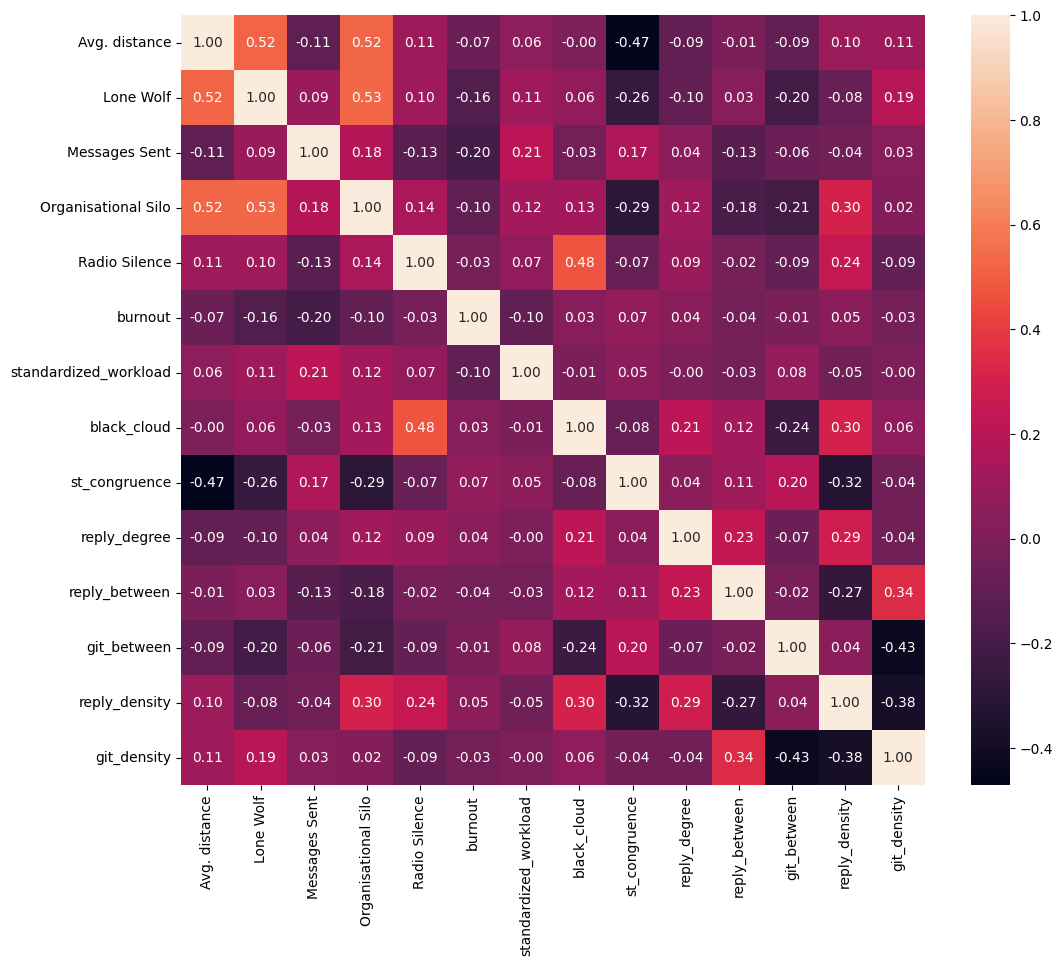

In [9]:
fig = plt.figure(figsize=(12,10))
ax= plt.subplot()
sns.heatmap(logistic_train_data.astype(float).corr(), annot=True, ax = ax, fmt = '.2f');
fig.savefig('correlations_geronimo.png')

In [10]:
lr_model = LogisticRegressionCV(max_iter = 1000000).fit(logistic_train_data.drop('burnout', axis = 1), logistic_train_data['burnout'])

Text(45.722222222222214, 0.5, 'True class')

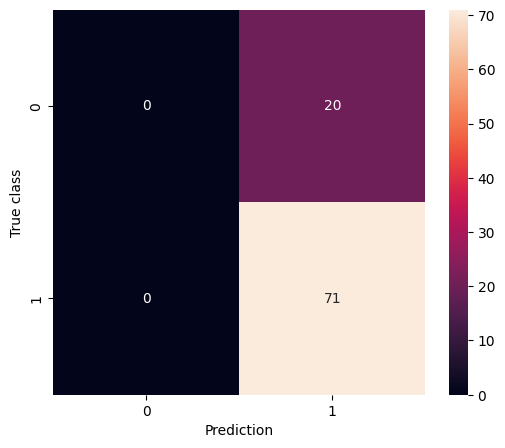

In [11]:
cm = confusion_matrix(logistic_test_data['burnout'], lr_model.predict(logistic_test_data.drop('burnout', axis = 1)))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

statsmodels

In [12]:
stat_model = sm.Logit(logistic_train_data['burnout'].astype(float), sm.add_constant(logistic_train_data.drop('burnout', axis = 1)).astype(float)).fit(disp = 0)
stat_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                burnout   No. Observations:                  364
Model:                          Logit   Df Residuals:                      350
Method:                           MLE   Df Model:                           13
Date:                Thu, 29 May 2025   Pseudo R-squ.:                 0.08260
Time:                        00:38:53   Log-Likelihood:                -175.86
converged:                       True   LL-Null:                       -191.69
Covariance Type:            nonrobust   LLR p-value:                  0.002691
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.8651      1.509      1.236      0.216      -1.092       4.822
Avg. distance             0.1262      0.194      0.650      0.516      -0.254       0.507
Lone Wolf                -1.3054      0.705     -1.851      0.064      -2.687       0.077
Messages Sent            -0.0101      0.003     -3.349      0.001      -0.016      -0.004
Organisational Silo      -0.1525      0.394     -0.387      0.699      -0.925       0.620
Radio Silence            -0.4133      0.309     -1.338      0.181      -1.018       0.192
standardized_workload    -0.0210      0.036     -0.579      0.563      -0.092       0.050
black_cloud               0.4270      0.493      0.867      0.386      -0.539       1.392
st_congruence             2.1037      1.055      1.994      0.046       0.036       4.171
reply_degree              1.4359      2.638      0.544      0.586      -3.734       6.605
reply_between            -4.2712      3.006     -1.421      0.155     -10.163       1.620
git_between              -1.1809      1.248     -0.946      0.344      -3.627       1.265
reply_density             1.7543      2.818      0.623      0.534      -3.768       7.277
git_density               0.1368      0.956      0.143      0.886      -1.738       2.011
=========================================================================================
"""

Text(45.722222222222214, 0.5, 'True class')

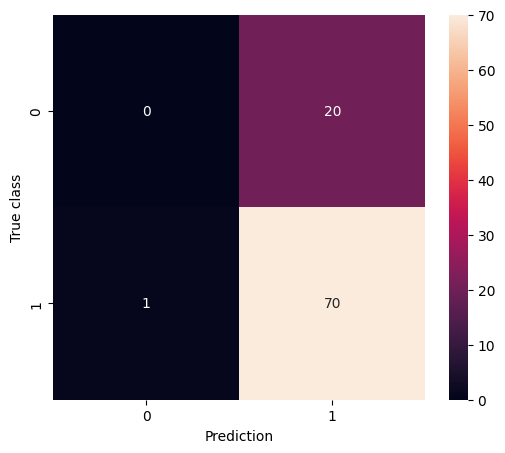

In [13]:
cm = confusion_matrix(logistic_test_data['burnout'], round(stat_model.predict(sm.add_constant(logistic_test_data.drop('burnout', axis = 1)).astype(float))).astype(int))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

### Burnout NB

In [16]:
message_data = all_test[['reply_body', 'burnout']].dropna()

nlp = spacy.load('en_core_web_sm')
tqdm.pandas()

message_data['lemmas'] = message_data.reply_body.progress_apply(lambda x: [token.lemma_ for token in nlp(handle_negation(x)) if not token.is_stop and token.is_alpha])
message_data['burnout'] = message_data['burnout'].astype(bool)
message_data

100%|██████████| 7607/7607 [01:52<00:00, 67.63it/s] 


,reply_body,burnout,lemmas
255,"jetty, openejb, servicemix are all using it as...",True,"[jetty, openejb, servicemix, configuration, wa..."
257,+1 good,True,[good]
259,we were first voting to seethe servicemix wer...,True,"[vote, seethe, servicemix, willing, accept, gi..."
265,we kinda voted already on but changes so to c...,True,"[kinda, vote, change, clear, thing, open, arri..."
268,i have just applied 2 trivial bug fixes to the...,True,"[apply, trivial, bug, fix, xbean, spring, modu..."
...,...,...,...
22812,welcome you see a jira that you are it is not ...,True,"[welcome, jira, email, list, let, know, like, ..."
22813,i should have all of the necessary paperwork s...,True,"[necessary, paperwork, email, let, know, join,..."
22814,"hi all, i was wondering - is it possible to ha...",True,"[hi, wonder, possible, plugin, need, example, ..."
22815,"sorry joe, i just got back to my am glad it ch...",True,"[sorry, joe, get, glad, change, change, cause,..."


In [17]:
message_data = message_data[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 0]

message_train, message_test = train_test_split(message_data, test_size=0.15, random_state=404, stratify = message_data['burnout'])
message_train, message_val = train_test_split(message_train, test_size=(0.15/0.85), random_state=404, stratify = message_train['burnout'])

print(f'length of train set: {len(message_train)}\nlength of validation set: {len(message_val)}\nlength of test set: {len(message_test)}')
message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages

# Oversample on the True cases in the train set
if 2*message_train["burnout"].sum()<len(message_train):
   # True is the minority class
    if 3*message_train["burnout"].sum()<len(message_train):
        # We need to over- and undersample to create balance
        message_train = pd.concat([message_train.loc[message_train[message_train['burnout']==1].index], message_train])
        print(f'Positive cases: {message_train["burnout"].sum()}')

        if 3*message_train["burnout"].sum()<len(message_train):
            # Check for massive imbalance
            message_train = pd.concat([message_train.loc[message_train[message_train['burnout']==1].index], message_train])
            print(f'Positive cases: {message_train["burnout"].sum()}')

        nMax = message_train["burnout"].sum()
        message_train = message_train.groupby('burnout').apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')
    else:
        nMax = message_train["burnout"].sum()
        # Only undersampling will do
        print(f'Positive cases: {message_train["burnout"].sum()}')
        message_train = message_train.groupby('burnout').apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')


else:
    if message_train["burnout"].sum()>0.67*len(message_train):
        # False is the minority class and we need to over- and undersample
        message_train = pd.concat([message_train.loc[message_train[message_train['burnout']==0].index], message_train])
        print(f'Positive cases: {message_train["burnout"].sum()}')

        if message_train["burnout"].sum()>0.67*len(message_train):
            # Check for massive imbalance (mainly ragequit case)
            message_train = pd.concat([message_train.loc[message_train[message_train['burnout']==0].index], message_train])
            print(f'Positive cases: {message_train["burnout"].sum()}')

        nMax = len(message_train) - message_train["burnout"].sum()
        message_train = message_train.groupby('burnout').apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

    else:
        nMax = len(message_train) - message_train["burnout"].sum()
        print(f'Positive cases: {message_train["burnout"].sum()}')
        message_train = message_train.groupby('burnout').apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

C:\Users\woute\AppData\Local\Temp\ipykernel_11104\1081622227.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages
C:\Users\woute\AppData\Local\Temp\ipykernel_11104\1081622227.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  message_train = message_train.groupby('burnout').apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)


length of train set: 5151
length of validation set: 1104
length of test set: 1104
Positive cases: 2372
New length of train set: 4744


In [18]:
pos_labels, pos_values = zip(*Counter(itertools.chain(*message_data[message_data['burnout']].lemmas.tolist())).items())
neg_labels, neg_values = zip(*Counter(itertools.chain(*message_data[~message_data['burnout']].lemmas.tolist())).items())

importance_df = pd.DataFrame(index = list(set(pos_labels + neg_labels)), data = {'pos_occur': pd.Series(pos_values, index = pos_labels), 'neg_occur': pd.Series(neg_values, index = neg_labels)})
importance_df.fillna(0, inplace = True)
importance_df['total_appearances'] = importance_df['pos_occur'] + importance_df['neg_occur']

for i in range(0,125,25):
    p = i
    importance_df['pos_importance'] = (importance_df['pos_occur'] + p)/(importance_df['total_appearances']+2*p)
    importance_df['neg_importance'] = (importance_df['neg_occur'] + p)/(importance_df['total_appearances']+2*p)
    print(f'positive {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'pos_importance', ascending = False)[['pos_importance', 'pos_occur', 'total_appearances']].head(20))
    print(f'negative {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'neg_importance', ascending = False)[['neg_importance', 'neg_occur', 'total_appearances']].head(20))
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

positive 0:
             pos_importance  pos_occur  total_appearances
repository         0.571429      188.0              329.0
community          0.538462       56.0              104.0
setup              0.530973       60.0              113.0
folk               0.496403       69.0              139.0
unable             0.492754       68.0              138.0
recommend          0.481481       52.0              108.0
download           0.472222      119.0              252.0
exception          0.457944       49.0              107.0
project            0.457594      232.0              507.0
mvn                0.447236       89.0              199.0
tck                0.444444       48.0              108.0
transaction        0.440559       63.0              143.0
branch             0.426966       76.0              178.0
component          0.426778      102.0              239.0
reason             0.426471       87.0              204.0
happen             0.425532       60.0              141.0
fi

In [19]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000), max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = MultinomialNB()
classifier.fit(train_tf, message_train['burnout'])

classification_report(message_val['burnout'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.77      0.66      0.71       791\n        True       0.37      0.50      0.42       313\n\n    accuracy                           0.62      1104\n   macro avg       0.57      0.58      0.57      1104\nweighted avg       0.66      0.62      0.63      1104\n'

Text(45.722222222222214, 0.5, 'True class')

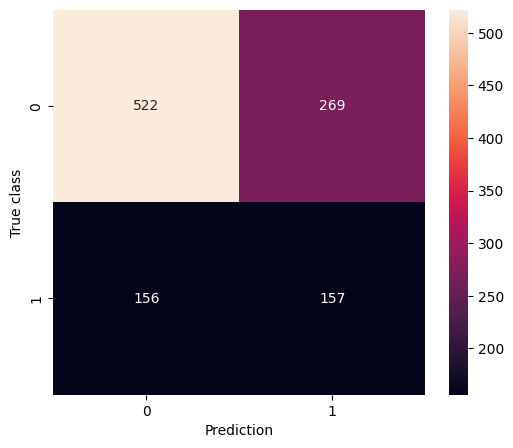

In [20]:
cm = confusion_matrix(message_val['burnout'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [21]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout'])

classification_report(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.75      0.39      0.52       791\n        True       0.31      0.68      0.42       313\n\n    accuracy                           0.47      1104\n   macro avg       0.53      0.53      0.47      1104\nweighted avg       0.63      0.47      0.49      1104\n'

Text(45.722222222222214, 0.5, 'True class')

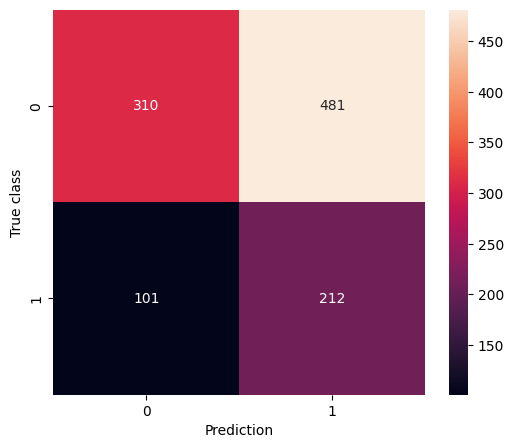

In [22]:
cm = confusion_matrix(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [23]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout'])

classification_report(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.75      0.51      0.61       791\n        True       0.32      0.57      0.41       313\n\n    accuracy                           0.53      1104\n   macro avg       0.53      0.54      0.51      1104\nweighted avg       0.63      0.53      0.55      1104\n'

Text(45.722222222222214, 0.5, 'True class')

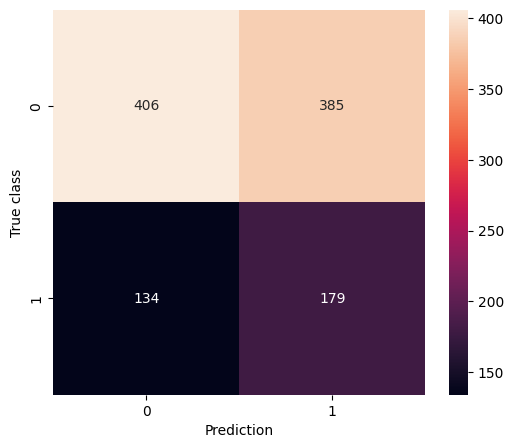

In [24]:
cm = confusion_matrix(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# RF models

In [25]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000), max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(train_tf, message_train['burnout'])

classification_report(message_val['burnout'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.74      0.78      0.76       791\n        True       0.35      0.30      0.32       313\n\n    accuracy                           0.64      1104\n   macro avg       0.54      0.54      0.54      1104\nweighted avg       0.63      0.64      0.64      1104\n'

Text(45.722222222222214, 0.5, 'True class')

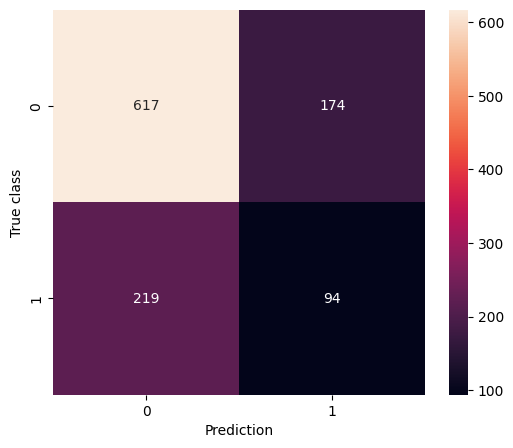

In [26]:
cm = confusion_matrix(message_val['burnout'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [27]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout'])

classification_report(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.73      0.84      0.78       791\n        True       0.34      0.20      0.25       313\n\n    accuracy                           0.66      1104\n   macro avg       0.53      0.52      0.52      1104\nweighted avg       0.62      0.66      0.63      1104\n'

Text(45.722222222222214, 0.5, 'True class')

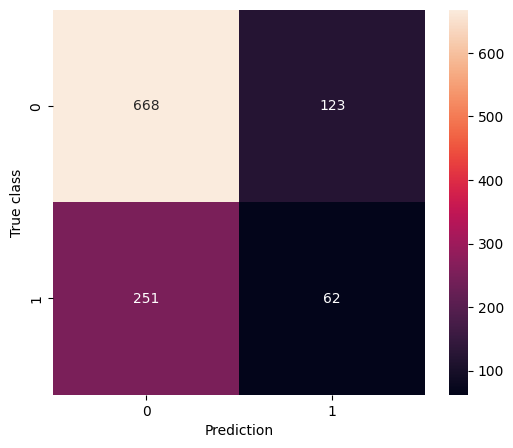

In [28]:
cm = confusion_matrix(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [29]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout'])

classification_report(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.73      0.97      0.83       791\n        True       0.54      0.10      0.16       313\n\n    accuracy                           0.72      1104\n   macro avg       0.63      0.53      0.50      1104\nweighted avg       0.67      0.72      0.64      1104\n'

Text(45.722222222222214, 0.5, 'True class')

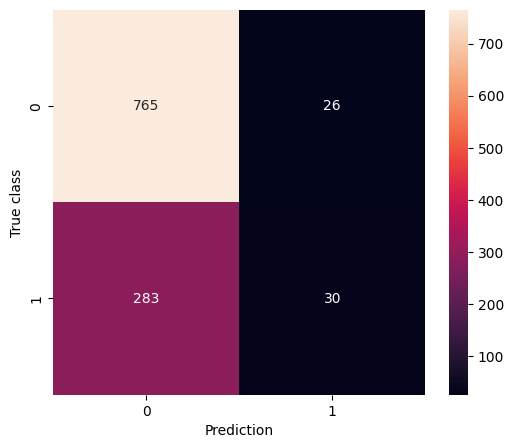

In [30]:
cm = confusion_matrix(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# Ragequit - LR

sklearn

In [31]:
burnout_logistic_data = logistic_data[~logistic_data['ragequit_t+1'].isna()].drop(['burnout_t+1', 'burnout_t+3', 'burnout_t+12', 'burnout', 'ragequit_t+3', 'ragequit_t+12', 'git_close'], axis = 1).drop_duplicates().drop(['Alias', 'From', 'To', 'start_datetime', 'end_datetime', 'lagged_burnout', 'reply_close', 'working_months', 'quit', 'first_quit_month', 'git_degree', 'Workload'], axis = 1).dropna().astype({'ragequit_t+1':bool})
logistic_train_data, logistic_test_data = train_test_split(burnout_logistic_data, test_size = 0.2, random_state = 409084, stratify = burnout_logistic_data[['ragequit_t+1']])

In [32]:
logistic_train_data.describe(include = 'all')

,Avg. distance,Lone Wolf,Messages Sent,Organisational Silo,Radio Silence,standardized_workload,black_cloud,ragequit_t+1,st_congruence,reply_degree,reply_between,git_between,reply_density,git_density
count,364.000000,364,364.000000,364,364,364.000000,364,364,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000
unique,NaN,2,NaN,2,2,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,True,NaN,True,False,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,309,NaN,228,209,NaN,310,362,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.271746,NaN,37.750000,NaN,NaN,1.260427,NaN,NaN,0.430551,0.367060,0.109991,0.224491,0.158479,0.463989
std,0.999866,NaN,41.256914,NaN,NaN,3.674371,NaN,NaN,0.171548,0.058634,0.050849,0.132282,0.067702,0.178732
min,1.000000,NaN,1.000000,NaN,NaN,0.000115,NaN,NaN,0.161290,0.169683,0.048921,0.008818,0.040742,0.158333
25%,1.555556,NaN,12.000000,NaN,NaN,0.025274,NaN,NaN,0.300000,0.328469,0.073195,0.133333,0.107071,0.342424
50%,2.200000,NaN,26.000000,NaN,NaN,0.201502,NaN,NaN,0.393939,0.367255,0.092181,0.193846,0.159268,0.457895
75%,2.800000,NaN,52.000000,NaN,NaN,0.921984,NaN,NaN,0.567568,0.396552,0.139065,0.299320,0.187500,0.555556


In [33]:
lr_model = LogisticRegressionCV(max_iter = 1000000).fit(logistic_train_data.drop('ragequit_t+1', axis = 1), logistic_train_data['ragequit_t+1'])

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Text(45.722222222222214, 0.5, 'True class')

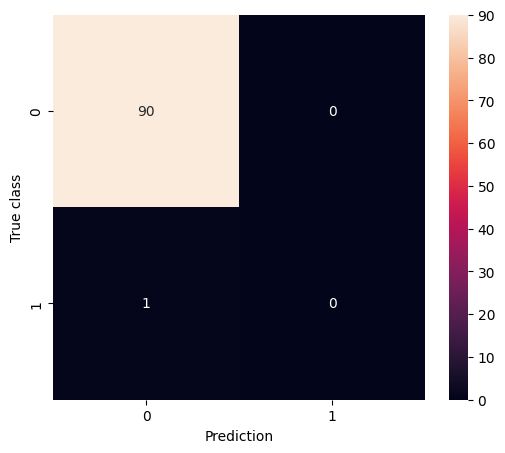

In [34]:
cm = confusion_matrix(logistic_test_data['ragequit_t+1'], lr_model.predict(logistic_test_data.drop('ragequit_t+1', axis = 1)))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

statsmodels

In [36]:
stat_model = sm.Logit(logistic_train_data['ragequit_t+1'].astype(float), sm.add_constant(logistic_train_data[['Avg. distance', 'Lone Wolf', 'standardized_workload',
 'Organisational Silo', 'Radio Silence',  'black_cloud', 'Messages Sent', 'st_congruence']]).astype(float)).fit(disp = 0)
stat_model.summary()

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           ragequit_t+1   No. Observations:                  364
Model:                          Logit   Df Residuals:                      355
Method:                           MLE   Df Model:                            8
Date:                Thu, 29 May 2025   Pseudo R-squ.:                  0.2550
Time:                        00:45:59   Log-Likelihood:                -9.2399
converged:                      False   LL-Null:                       -12.403
Covariance Type:            nonrobust   LLR p-value:                    0.6108
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -13.8193   1536.900     -0.009      0.993   -3026.087    2998.449
Avg. distance            -1.2066      1.508     -0.800      0.424      -4.163       1.750
Lone Wolf                10.8452   1536.913      0.007      0.994   -3001.450    3023.140
standardized_workload     0.0449      0.485      0.093      0.926      -0.905       0.995
Organisational Silo       4.7165      7.609      0.620      0.535     -10.196      19.629
Radio Silence           -18.3556   9150.046     -0.002      0.998    -1.8e+04    1.79e+04
black_cloud              -2.2685   3.62e+04  -6.26e-05      1.000    -7.1e+04     7.1e+04
Messages Sent            -0.0309      0.043     -0.725      0.468      -0.114       0.053
st_congruence            -5.1428      7.361     -0.699      0.485     -19.570       9.285
=========================================================================================

Possibly complete quasi-separation: A fraction 0.58 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Text(45.722222222222214, 0.5, 'True class')

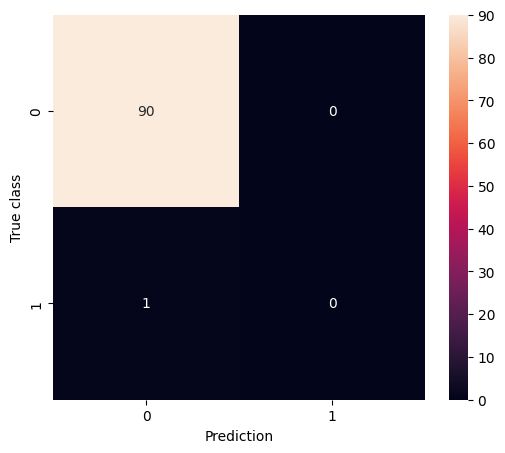

In [38]:
cm = confusion_matrix(logistic_test_data['ragequit_t+1'], round(stat_model.predict(sm.add_constant(logistic_test_data[['Avg. distance', 'Lone Wolf', 'standardized_workload',
 'Organisational Silo', 'Radio Silence',  'black_cloud', 'Messages Sent', 'st_congruence']]).astype(float))).astype(int))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

### Burnout NB

In [39]:
message_data = all_test[['reply_body', 'ragequit_t+1']].dropna()

nlp = spacy.load('en_core_web_sm')
tqdm.pandas()

message_data['lemmas'] = message_data.reply_body.progress_apply(lambda x: [token.lemma_ for token in nlp(handle_negation(x)) if not token.is_stop and token.is_alpha])
message_data['ragequit_t+1'] = message_data['ragequit_t+1'].astype(bool)
message_data

100%|██████████| 20241/20241 [04:58<00:00, 67.82it/s] 


,reply_body,ragequit_t+1,lemmas
6,appliedcommitted,False,[appliedcommitte]
7,proxy server received an invalid response from...,False,"[proxy, server, receive, invalid, response, up..."
8,"we actually could use that, as we have a trad...",False,"[actually, use, trademark, asf, want, add, sur..."
10,my vote would be m5 so we out.,False,[vote]
11,that is the beautiful part of is not Positive...,False,"[beautiful, PositiveSentiment]"
...,...,...,...
22813,i should have all of the necessary paperwork s...,False,"[necessary, paperwork, email, let, know, join,..."
22814,"hi all, i was wondering - is it possible to ha...",False,"[hi, wonder, possible, plugin, need, example, ..."
22815,"sorry joe, i just got back to my am glad it ch...",False,"[sorry, joe, get, glad, change, change, cause,..."
22816,i think the subject is think about that ?,False,"[think, subject, think]"


In [40]:
message_data = message_data[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 0]

message_train, message_test = train_test_split(message_data, test_size=0.15, random_state=404, stratify = message_data['ragequit_t+1'])
message_train, message_val = train_test_split(message_train, test_size=(0.15/0.85), random_state=404, stratify = message_train['ragequit_t+1'])

print(f'length of train set: {len(message_train)}\nlength of validation set: {len(message_val)}\nlength of test set: {len(message_test)}')
message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages

# Oversample on the True cases in the train set
if 2*message_train["ragequit_t+1"].sum()<len(message_train):
   # True is the minority class
    if 3*message_train["ragequit_t+1"].sum()<len(message_train):
        # We need to over- and undersample to create balance
        message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+1"]==1].index], message_train])
        print(f'Positive cases: {message_train["ragequit_t+1"].sum()}')

        if 3*message_train["ragequit_t+1"].sum()<len(message_train):
            # Check for massive imbalance
            message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+1"]==1].index], message_train])
            print(f'Positive cases: {message_train["ragequit_t+1"].sum()}')

        nMax = message_train["ragequit_t+1"].sum()
        message_train = message_train.groupby("ragequit_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')
    else:
        nMax = message_train["ragequit_t+1"].sum()
        # Only undersampling will do
        print(f'Positive cases: {message_train["ragequit_t+1"].sum()}')
        message_train = message_train.groupby("ragequit_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')


else:
    if message_train["ragequit_t+1"].sum()>0.67*len(message_train):
        # False is the minority class and we need to over- and undersample
        message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+1"]==0].index], message_train])
        print(f'Positive cases: {message_train["ragequit_t+1"].sum()}')

        if message_train["ragequit_t+1"].sum()>0.67*len(message_train):
            # Check for massive imbalance (mainly ragequit case)
            message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+1"]==0].index], message_train])
            print(f'Positive cases: {message_train["ragequit_t+1"].sum()}')

        nMax = len(message_train) - message_train["ragequit_t+1"].sum()
        message_train = message_train.groupby("ragequit_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

    else:
        nMax = len(message_train) - message_train["ragequit_t+1"].sum()
        print(f'Positive cases: {message_train["ragequit_t+1"].sum()}')
        message_train = message_train.groupby("ragequit_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

length of train set: 13617
length of validation set: 2918
length of test set: 2918
Positive cases: 432
Positive cases: 1296
New length of train set: 2592


C:\Users\woute\AppData\Local\Temp\ipykernel_11104\1360335003.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages
C:\Users\woute\AppData\Local\Temp\ipykernel_11104\1360335003.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  message_train = message_train.groupby("ragequit_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)


In [41]:
pos_labels, pos_values = zip(*Counter(itertools.chain(*message_data[message_data['ragequit_t+1']].lemmas.tolist())).items())
neg_labels, neg_values = zip(*Counter(itertools.chain(*message_data[~message_data['ragequit_t+1']].lemmas.tolist())).items())

importance_df = pd.DataFrame(index = list(set(pos_labels + neg_labels)), data = {'pos_occur': pd.Series(pos_values, index = pos_labels), 'neg_occur': pd.Series(neg_values, index = neg_labels)})
importance_df.fillna(0, inplace = True)
importance_df['total_appearances'] = importance_df['pos_occur'] + importance_df['neg_occur']

for i in range(0,125,25):
    p = i
    importance_df['pos_importance'] = (importance_df['pos_occur'] + p)/(importance_df['total_appearances']+2*p)
    importance_df['neg_importance'] = (importance_df['neg_occur'] + p)/(importance_df['total_appearances']+2*p)
    print(f'positive {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'pos_importance', ascending = False)[['pos_importance', 'pos_occur', 'total_appearances']].head(20))
    print(f'negative {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'neg_importance', ascending = False)[['neg_importance', 'neg_occur', 'total_appearances']].head(20))
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

positive 0:
                     pos_importance  pos_occur  total_appearances
startmbeaninstance         1.000000      107.0              107.0
checkingtask               1.000000      167.0              167.0
deploymentplan             1.000000      475.0              475.0
deploygeronimombean        1.000000      163.0              163.0
geronimombean              0.948454      184.0              194.0
band                       0.858491       91.0              106.0
trace                      0.849807      662.0              779.0
true                       0.680000      170.0              250.0
task                       0.656716      308.0              469.0
role                       0.602837      255.0              423.0
perform                    0.563707      146.0              259.0
answer                     0.536364      177.0              330.0
perl                       0.463950      148.0              319.0
parse                      0.454023       79.0              174.

In [42]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000), max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = MultinomialNB()
classifier.fit(train_tf, message_train['ragequit_t+1'])

classification_report(message_val['ragequit_t+1'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.99      0.88      0.93      2864\n        True       0.10      0.70      0.17        54\n\n    accuracy                           0.88      2918\n   macro avg       0.55      0.79      0.55      2918\nweighted avg       0.98      0.88      0.92      2918\n'

Text(45.722222222222214, 0.5, 'True class')

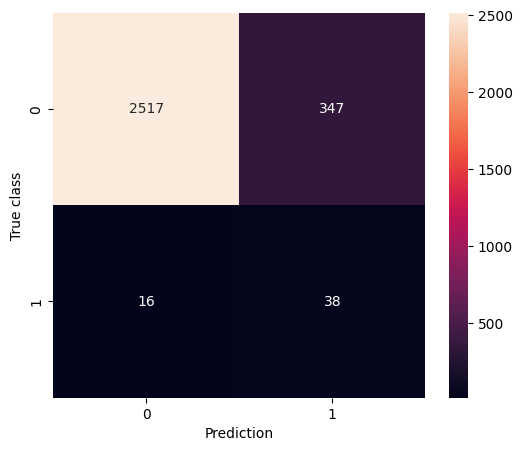

In [43]:
cm = confusion_matrix(message_val['ragequit_t+1'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [44]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_train.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+1'])

classification_report(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.99      0.91      0.95      2864\n        True       0.11      0.57      0.18        54\n\n    accuracy                           0.90      2918\n   macro avg       0.55      0.74      0.56      2918\nweighted avg       0.97      0.90      0.93      2918\n'

Text(45.722222222222214, 0.5, 'True class')

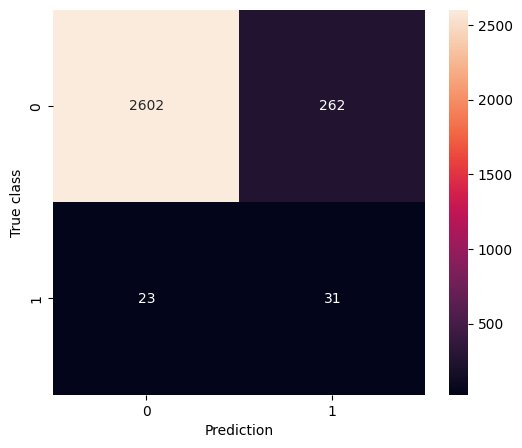

In [45]:
cm = confusion_matrix(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [46]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+1'])

classification_report(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.99      0.70      0.82      2864\n        True       0.04      0.70      0.08        54\n\n    accuracy                           0.70      2918\n   macro avg       0.52      0.70      0.45      2918\nweighted avg       0.97      0.70      0.81      2918\n'

Text(45.722222222222214, 0.5, 'True class')

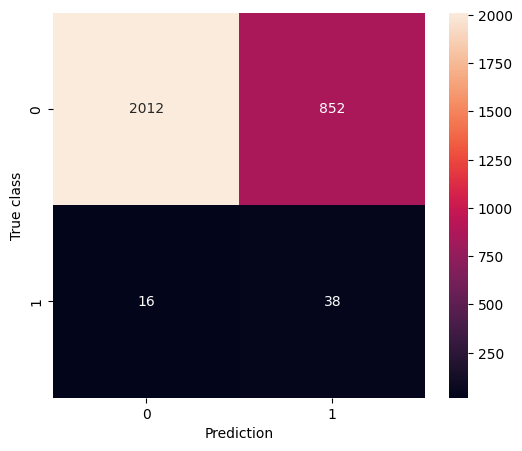

In [47]:
cm = confusion_matrix(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# RF models

In [48]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000), max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(train_tf, message_train['ragequit_t+1'])

classification_report(message_val['ragequit_t+1'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       1.00      0.99      0.99      2864\n        True       0.61      0.80      0.69        54\n\n    accuracy                           0.99      2918\n   macro avg       0.81      0.89      0.84      2918\nweighted avg       0.99      0.99      0.99      2918\n'

Text(45.722222222222214, 0.5, 'True class')

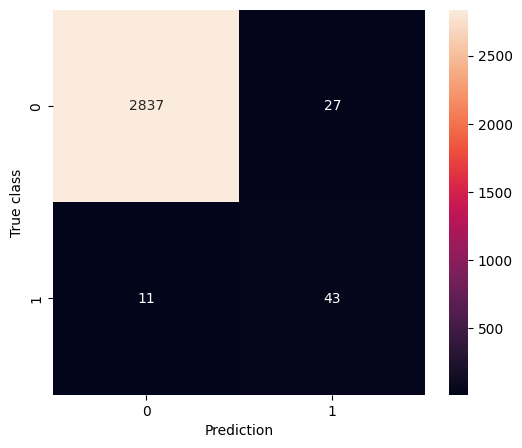

In [49]:
cm = confusion_matrix(message_val['ragequit_t+1'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [50]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_train.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+1'])

classification_report(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.99      0.99      0.99      2864\n        True       0.47      0.56      0.51        54\n\n    accuracy                           0.98      2918\n   macro avg       0.73      0.77      0.75      2918\nweighted avg       0.98      0.98      0.98      2918\n'

Text(45.722222222222214, 0.5, 'True class')

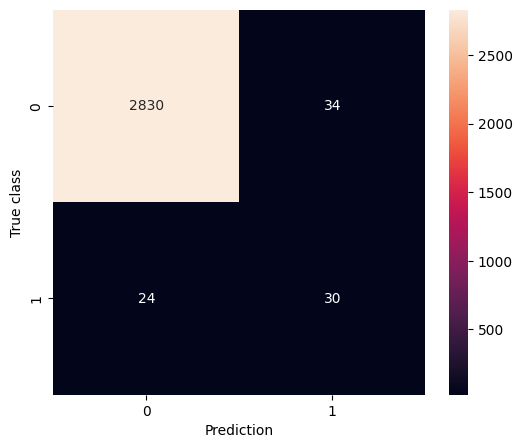

In [51]:
cm = confusion_matrix(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [52]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+1'])

classification_report(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.99      0.99      0.99      2864\n        True       0.45      0.41      0.43        54\n\n    accuracy                           0.98      2918\n   macro avg       0.72      0.70      0.71      2918\nweighted avg       0.98      0.98      0.98      2918\n'

Text(45.722222222222214, 0.5, 'True class')

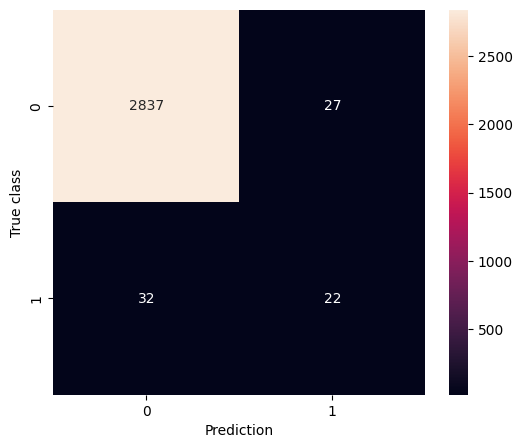

In [53]:
cm = confusion_matrix(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# Lagged variables

## Burnout t+1

In [54]:
burnout_logistic_data = logistic_data[~logistic_data.burnout.isna()].drop(['burnout', 'burnout_t+3', 'burnout_t+12', 'ragequit_t+1', 'ragequit_t+3', 'ragequit_t+12', 'git_close'], axis = 1).drop_duplicates().drop(['Alias', 'From', 'To', 'start_datetime', 'end_datetime', 'lagged_burnout', 'reply_close', 'working_months', 'quit', 'first_quit_month', 'git_degree', 'Workload'], axis = 1).dropna().astype({'burnout_t+1':bool})
logistic_train_data, logistic_test_data = train_test_split(burnout_logistic_data, test_size = 0.2, random_state = 404, stratify = burnout_logistic_data['burnout_t+1'])

In [55]:
lr_model = LogisticRegressionCV(max_iter = 1000000).fit(logistic_train_data.drop('burnout_t+1', axis = 1), logistic_train_data['burnout_t+1'])

Text(45.722222222222214, 0.5, 'True class')

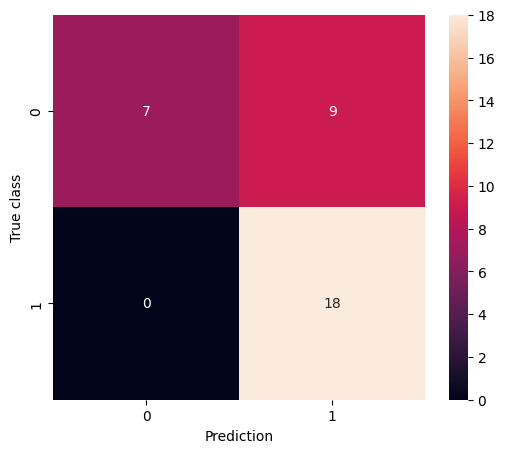

In [56]:
cm = confusion_matrix(logistic_test_data['burnout_t+1'], lr_model.predict(logistic_test_data.drop('burnout_t+1', axis = 1)))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

statsmodels

In [57]:
stat_model = sm.Logit(logistic_train_data['burnout_t+1'].astype(float), sm.add_constant(logistic_train_data.drop('burnout_t+1', axis = 1)).astype(float)).fit(disp = 0)
stat_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            burnout_t+1   No. Observations:                  134
Model:                          Logit   Df Residuals:                      120
Method:                           MLE   Df Model:                           13
Date:                Thu, 29 May 2025   Pseudo R-squ.:                  0.1173
Time:                        00:52:45   Log-Likelihood:                -81.930
converged:                       True   LL-Null:                       -92.822
Covariance Type:            nonrobust   LLR p-value:                   0.05879
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.6137      1.933     -0.318      0.751      -4.402       3.175
Avg. distance            -0.0294      0.278     -0.106      0.916      -0.575       0.516
Lone Wolf                 0.0310      0.805      0.038      0.969      -1.548       1.610
Messages Sent             0.0027      0.004      0.631      0.528      -0.006       0.011
Organisational Silo      -0.2071      0.552     -0.375      0.708      -1.289       0.875
Radio Silence            -0.2263      0.470     -0.482      0.630      -1.147       0.695
standardized_workload    -0.5266      0.181     -2.903      0.004      -0.882      -0.171
black_cloud               0.4141      0.727      0.570      0.569      -1.011       1.839
st_congruence             0.6885      1.417      0.486      0.627      -2.088       3.465
reply_degree              3.4701      3.689      0.941      0.347      -3.760      10.700
reply_between            -6.9989      4.307     -1.625      0.104     -15.441       1.444
git_between               0.6289      1.695      0.371      0.711      -2.692       3.950
reply_density             0.4158      4.333      0.096      0.924      -8.077       8.909
git_density               0.9811      1.362      0.720      0.471      -1.689       3.651
=========================================================================================
"""

Text(45.722222222222214, 0.5, 'True class')

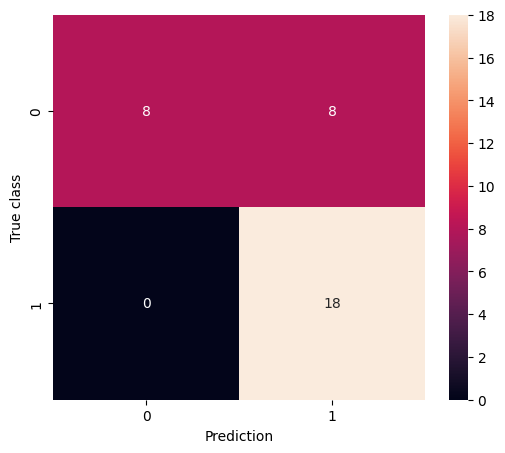

In [58]:
cm = confusion_matrix(logistic_test_data['burnout_t+1'], round(stat_model.predict(sm.add_constant(logistic_test_data.drop('burnout_t+1', axis = 1)).astype(float))).astype(int))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

### Burnout NB

In [59]:
message_data = all_test[['reply_body', 'burnout_t+1']].dropna()

nlp = spacy.load('en_core_web_sm')
tqdm.pandas()

message_data['lemmas'] = message_data.reply_body.progress_apply(lambda x: [token.lemma_ for token in nlp(handle_negation(x)) if not token.is_stop and token.is_alpha])
message_data['burnout_t+1'] = message_data['burnout_t+1'].astype(bool)
message_data

100%|██████████| 7988/7988 [01:42<00:00, 78.04it/s] 


,reply_body,burnout_t+1,lemmas
255,"jetty, openejb, servicemix are all using it as...",True,"[jetty, openejb, servicemix, configuration, wa..."
256,+1,True,[]
257,+1 good,True,[good]
259,we were first voting to seethe servicemix wer...,True,"[vote, seethe, servicemix, willing, accept, gi..."
265,we kinda voted already on but changes so to c...,True,"[kinda, vote, change, clear, thing, open, arri..."
...,...,...,...
22812,welcome you see a jira that you are it is not ...,True,"[welcome, jira, email, list, let, know, like, ..."
22813,i should have all of the necessary paperwork s...,True,"[necessary, paperwork, email, let, know, join,..."
22814,"hi all, i was wondering - is it possible to ha...",True,"[hi, wonder, possible, plugin, need, example, ..."
22815,"sorry joe, i just got back to my am glad it ch...",True,"[sorry, joe, get, glad, change, change, cause,..."


In [60]:
message_data = message_data[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 0]

message_train, message_test = train_test_split(message_data, test_size=0.15, random_state=404, stratify = message_data['burnout_t+1'])
message_train, message_val = train_test_split(message_train, test_size=(0.15/0.85), random_state=404, stratify = message_train['burnout_t+1'])

print(f'length of train set: {len(message_train)}\nlength of validation set: {len(message_val)}\nlength of test set: {len(message_test)}')
message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages

# Oversample on the True cases in the train set
if 2*message_train["burnout_t+1"].sum()<len(message_train):
   # True is the minority class
    if 3*message_train["burnout_t+1"].sum()<len(message_train):
        # We need to over- and undersample to create balance
        message_train = pd.concat([message_train.loc[message_train[message_train['burnout_t+1']==1].index], message_train])
        print(f'Positive cases: {message_train["burnout_t+1"].sum()}')

        if 3*message_train["burnout_t+1"].sum()<len(message_train):
            # Check for massive imbalance
            message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+1"]==1].index], message_train])
            print(f'Positive cases: {message_train["burnout_t+1"].sum()}')

        nMax = message_train["burnout_t+1"].sum()
        message_train = message_train.groupby("burnout_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')
    else:
        nMax = message_train["burnout_t+1"].sum()
        # Only undersampling will do
        print(f'Positive cases: {message_train["burnout_t+1"].sum()}')
        message_train = message_train.groupby("burnout_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')


else:
    if message_train["burnout_t+1"].sum()>0.67*len(message_train):
        # False is the minority class and we need to over- and undersample
        message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+1"]==0].index], message_train])
        print(f'Positive cases: {message_train["burnout_t+1"].sum()}')

        if message_train["burnout_t+1"].sum()>0.67*len(message_train):
            # Check for massive imbalance (mainly ragequit case)
            message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+1"]==0].index], message_train])
            print(f'Positive cases: {message_train["burnout_t+1"].sum()}')

        nMax = len(message_train) - message_train["burnout_t+1"].sum()
        message_train = message_train.groupby("burnout_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

    else:
        nMax = len(message_train) - message_train["burnout_t+1"].sum()
        print(f'Positive cases: {message_train["burnout_t+1"].sum()}')
        message_train = message_train.groupby("burnout_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

C:\Users\woute\AppData\Local\Temp\ipykernel_11104\995443566.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages
C:\Users\woute\AppData\Local\Temp\ipykernel_11104\995443566.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  message_train = message_train.groupby("burnout_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)


length of train set: 5406
length of validation set: 1159
length of test set: 1159
Positive cases: 2159
New length of train set: 4318


In [61]:
pos_labels, pos_values = zip(*Counter(itertools.chain(*message_data[message_data['burnout_t+1']].lemmas.tolist())).items())
neg_labels, neg_values = zip(*Counter(itertools.chain(*message_data[~message_data['burnout_t+1']].lemmas.tolist())).items())

importance_df = pd.DataFrame(index = list(set(pos_labels + neg_labels)), data = {'pos_occur': pd.Series(pos_values, index = pos_labels), 'neg_occur': pd.Series(neg_values, index = neg_labels)})
importance_df.fillna(0, inplace = True)
importance_df['total_appearances'] = importance_df['pos_occur'] + importance_df['neg_occur']

for i in range(0,125,25):
    p = i
    importance_df['pos_importance'] = (importance_df['pos_occur'] + p)/(importance_df['total_appearances']+2*p)
    importance_df['neg_importance'] = (importance_df['neg_occur'] + p)/(importance_df['total_appearances']+2*p)
    print(f'positive {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'pos_importance', ascending = False)[['pos_importance', 'pos_occur', 'total_appearances']].head(20))
    print(f'negative {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'neg_importance', ascending = False)[['neg_importance', 'neg_occur', 'total_appearances']].head(20))
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

positive 0:
             pos_importance  pos_occur  total_appearances
cluster            0.785124       95.0              121.0
tck                0.750000       81.0              108.0
community          0.727273       80.0              110.0
mvn                0.726368      146.0              201.0
folk               0.711409      106.0              149.0
repository         0.689150      235.0              341.0
setup              0.678261       78.0              115.0
transaction        0.675325      104.0              154.0
recommend          0.672727       74.0              110.0
integration        0.658333       79.0              120.0
resolve            0.650718      136.0              209.0
compile            0.648148       70.0              108.0
xml                0.644444      145.0              225.0
download           0.641732      163.0              254.0
project            0.639847      334.0              522.0
patch              0.637883      229.0              359.0
in

In [62]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000), max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = MultinomialNB()
classifier.fit(train_tf, message_train['burnout_t+1'])

classification_report(message_val['burnout_t+1'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.59      0.58      0.58       589\n        True       0.57      0.58      0.58       570\n\n    accuracy                           0.58      1159\n   macro avg       0.58      0.58      0.58      1159\nweighted avg       0.58      0.58      0.58      1159\n'

Text(45.722222222222214, 0.5, 'True class')

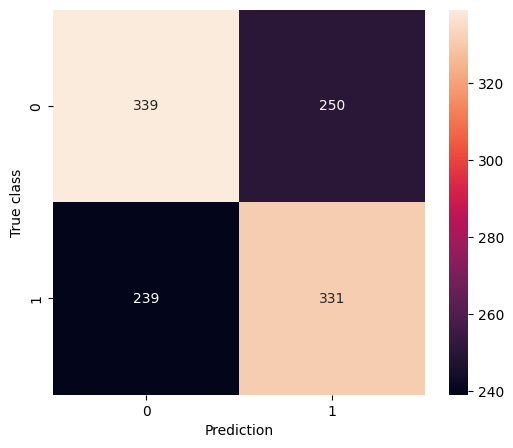

In [63]:
cm = confusion_matrix(message_val['burnout_t+1'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [64]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+1'])

classification_report(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.51      0.37      0.43       589\n        True       0.50      0.64      0.56       570\n\n    accuracy                           0.50      1159\n   macro avg       0.50      0.50      0.49      1159\nweighted avg       0.50      0.50      0.49      1159\n'

Text(45.722222222222214, 0.5, 'True class')

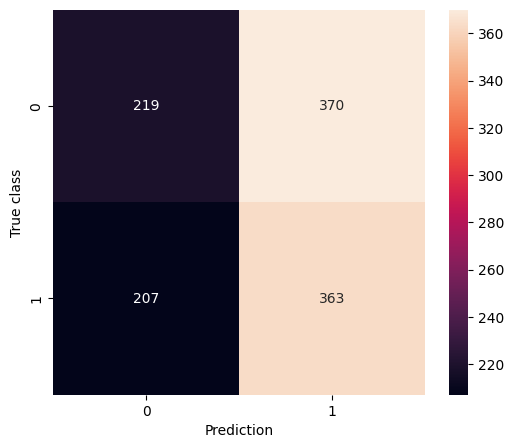

In [65]:
cm = confusion_matrix(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [66]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+1'])

classification_report(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.51      0.48      0.50       589\n        True       0.50      0.53      0.51       570\n\n    accuracy                           0.50      1159\n   macro avg       0.51      0.51      0.50      1159\nweighted avg       0.51      0.50      0.50      1159\n'

Text(45.722222222222214, 0.5, 'True class')

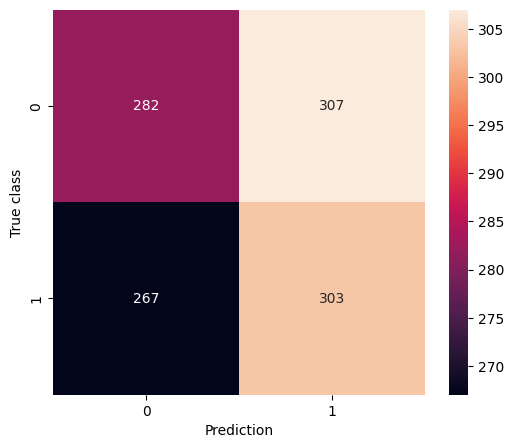

In [67]:
cm = confusion_matrix(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# RF models

In [68]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000), max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(train_tf, message_train['burnout_t+1'])

classification_report(message_val['burnout_t+1'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.59      0.54      0.56       589\n        True       0.56      0.60      0.58       570\n\n    accuracy                           0.57      1159\n   macro avg       0.57      0.57      0.57      1159\nweighted avg       0.57      0.57      0.57      1159\n'

Text(45.722222222222214, 0.5, 'True class')

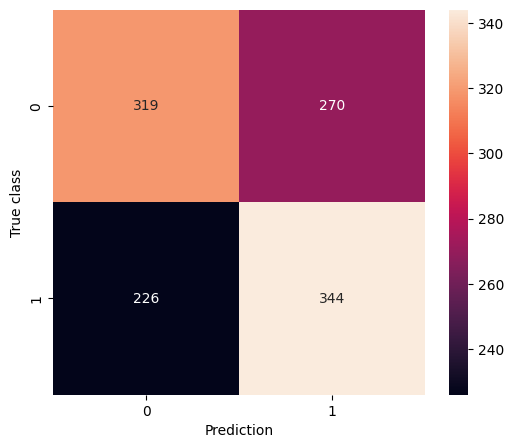

In [69]:
cm = confusion_matrix(message_val['burnout_t+1'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [70]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+1'])

classification_report(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.53      0.47      0.50       589\n        True       0.51      0.57      0.54       570\n\n    accuracy                           0.52      1159\n   macro avg       0.52      0.52      0.52      1159\nweighted avg       0.52      0.52      0.52      1159\n'

Text(45.722222222222214, 0.5, 'True class')

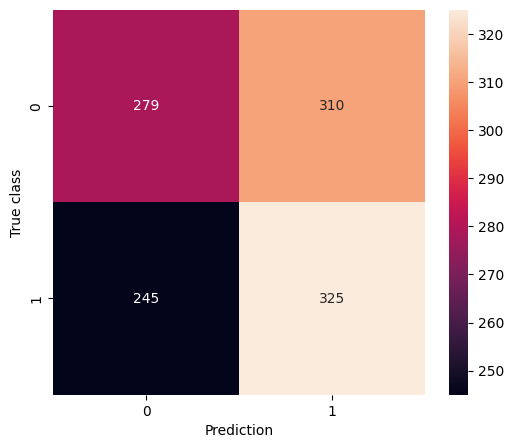

In [71]:
cm = confusion_matrix(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [72]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+1'])

classification_report(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.56      0.56      0.56       589\n        True       0.55      0.54      0.54       570\n\n    accuracy                           0.55      1159\n   macro avg       0.55      0.55      0.55      1159\nweighted avg       0.55      0.55      0.55      1159\n'

Text(45.722222222222214, 0.5, 'True class')

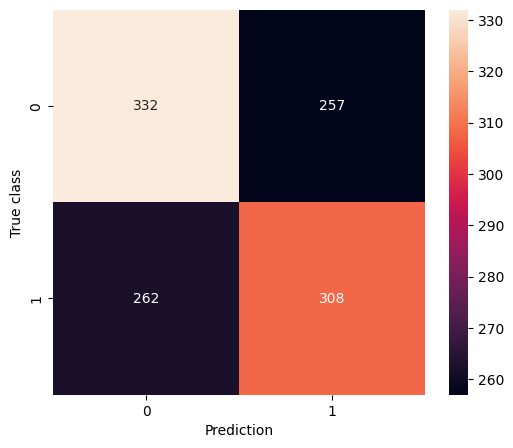

In [73]:
cm = confusion_matrix(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

## Burnout_t+3

In [74]:
burnout_logistic_data = logistic_data[~logistic_data.burnout.isna()].drop(['burnout_t+1', 'burnout', 'burnout_t+12', 'ragequit_t+1', 'ragequit_t+3', 'ragequit_t+12', 'git_close'], axis = 1).drop_duplicates().drop(['Alias', 'From', 'To', 'start_datetime', 'end_datetime', 'lagged_burnout', 'reply_close', 'working_months', 'quit', 'first_quit_month', 'git_degree', 'Workload'], axis = 1).dropna().astype({'burnout_t+3':bool})
logistic_train_data, logistic_test_data = train_test_split(burnout_logistic_data, test_size = 0.2, random_state = 404, stratify = burnout_logistic_data['burnout_t+3'])

In [75]:
lr_model = LogisticRegressionCV(max_iter = 1000000).fit(logistic_train_data.drop('burnout_t+3', axis = 1), logistic_train_data['burnout_t+3'])

Text(45.722222222222214, 0.5, 'True class')

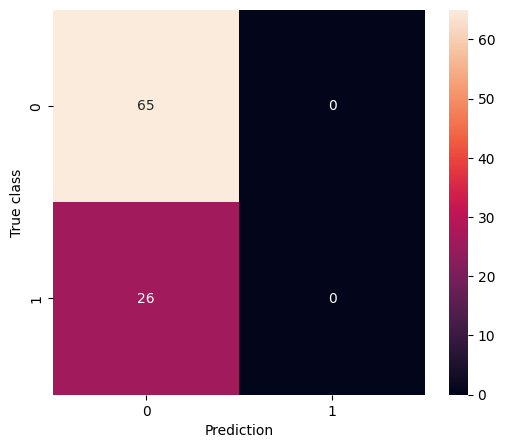

In [76]:
cm = confusion_matrix(logistic_test_data['burnout_t+3'], lr_model.predict(logistic_test_data.drop('burnout_t+3', axis = 1)))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

statsmodels

In [77]:
stat_model = sm.Logit(logistic_train_data['burnout_t+3'].astype(float), sm.add_constant(logistic_train_data.drop('burnout_t+3', axis = 1)).astype(float)).fit(disp = 0)
stat_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            burnout_t+3   No. Observations:                  364
Model:                          Logit   Df Residuals:                      350
Method:                           MLE   Df Model:                           13
Date:                Thu, 29 May 2025   Pseudo R-squ.:                 0.05143
Time:                        00:56:49   Log-Likelihood:                -207.43
converged:                       True   LL-Null:                       -218.68
Covariance Type:            nonrobust   LLR p-value:                   0.04818
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.4865      1.276      0.381      0.703      -2.015       2.988
Avg. distance            -0.0182      0.191     -0.095      0.924      -0.392       0.356
Lone Wolf                 0.5999      0.463      1.296      0.195      -0.307       1.507
Messages Sent             0.0047      0.003      1.754      0.079      -0.001       0.010
Organisational Silo      -0.0425      0.361     -0.118      0.906      -0.749       0.664
Radio Silence            -0.5783      0.306     -1.889      0.059      -1.178       0.022
standardized_workload    -0.0118      0.039     -0.305      0.760      -0.088       0.064
black_cloud               0.7282      0.447      1.630      0.103      -0.147       1.604
st_congruence            -0.3888      0.867     -0.448      0.654      -2.088       1.311
reply_degree             -5.5932      2.459     -2.275      0.023     -10.412      -0.774
reply_between            -1.3121      3.011     -0.436      0.663      -7.213       4.589
git_between               1.8237      1.018      1.791      0.073      -0.172       3.819
reply_density             0.0012      2.430      0.000      1.000      -4.762       4.764
git_density               0.0108      0.858      0.013      0.990      -1.670       1.692
=========================================================================================
"""

Text(45.722222222222214, 0.5, 'True class')

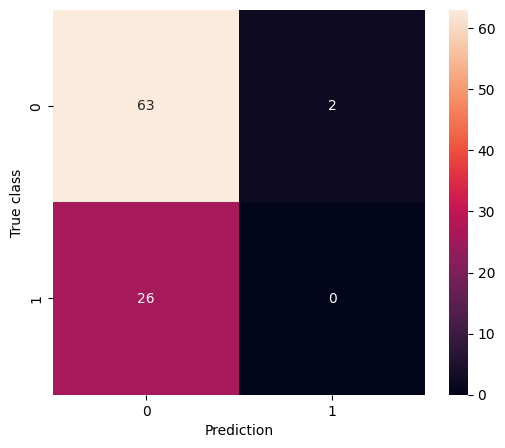

In [78]:
cm = confusion_matrix(logistic_test_data['burnout_t+3'], round(stat_model.predict(sm.add_constant(logistic_test_data.drop('burnout_t+3', axis = 1)).astype(float))).astype(int))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

### Burnout NB

In [79]:
message_data = all_test[['reply_body', 'burnout_t+3']].dropna()

nlp = spacy.load('en_core_web_sm')
tqdm.pandas()

message_data['lemmas'] = message_data.reply_body.progress_apply(lambda x: [token.lemma_ for token in nlp(handle_negation(x)) if not token.is_stop and token.is_alpha])
message_data['burnout_t+3'] = message_data['burnout_t+3'].astype(bool)
message_data

100%|██████████| 20241/20241 [04:26<00:00, 76.01it/s] 


,reply_body,burnout_t+3,lemmas
6,appliedcommitted,False,[appliedcommitte]
7,proxy server received an invalid response from...,False,"[proxy, server, receive, invalid, response, up..."
8,"we actually could use that, as we have a trad...",False,"[actually, use, trademark, asf, want, add, sur..."
10,my vote would be m5 so we out.,False,[vote]
11,that is the beautiful part of is not Positive...,False,"[beautiful, PositiveSentiment]"
...,...,...,...
22813,i should have all of the necessary paperwork s...,True,"[necessary, paperwork, email, let, know, join,..."
22814,"hi all, i was wondering - is it possible to ha...",True,"[hi, wonder, possible, plugin, need, example, ..."
22815,"sorry joe, i just got back to my am glad it ch...",True,"[sorry, joe, get, glad, change, change, cause,..."
22816,i think the subject is think about that ?,True,"[think, subject, think]"


In [80]:
message_data = message_data[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 0]

message_train, message_test = train_test_split(message_data, test_size=0.15, random_state=404, stratify = message_data['burnout_t+3'])
message_train, message_val = train_test_split(message_train, test_size=(0.15/0.85), random_state=404, stratify = message_train['burnout_t+3'])

print(f'length of train set: {len(message_train)}\nlength of validation set: {len(message_val)}\nlength of test set: {len(message_test)}')
message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages

# Oversample on the True cases in the train set
if 2*message_train["burnout_t+3"].sum()<len(message_train):
   # True is the minority class
    if 3*message_train["burnout_t+3"].sum()<len(message_train):
        # We need to over- and undersample to create balance
        message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+3"]==1].index], message_train])
        print(f'Positive cases: {message_train["burnout_t+3"].sum()}')

        if 3*message_train["burnout_t+3"].sum()<len(message_train):
            # Check for massive imbalance
            message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+3"]==1].index], message_train])
            print(f'Positive cases: {message_train["burnout_t+3"].sum()}')

        nMax = message_train["burnout_t+3"].sum()
        message_train = message_train.groupby("burnout_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')
    else:
        nMax = message_train["burnout_t+3"].sum()
        # Only undersampling will do
        print(f'Positive cases: {message_train["burnout_t+3"].sum()}')
        message_train = message_train.groupby("burnout_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')


else:
    if message_train["burnout_t+3"].sum()>0.67*len(message_train):
        # False is the minority class and we need to over- and undersample
        message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+3"]==0].index], message_train])
        print(f'Positive cases: {message_train["burnout_t+3"].sum()}')

        if message_train["burnout_t+3"].sum()>0.67*len(message_train):
            # Check for massive imbalance (mainly ragequit case)
            message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+3"]==0].index], message_train])
            print(f'Positive cases: {message_train["burnout_t+3"].sum()}')

        nMax = len(message_train) - message_train["burnout_t+3"].sum()
        message_train = message_train.groupby("burnout_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

    else:
        nMax = len(message_train) - message_train["burnout_t+3"].sum()
        print(f'Positive cases: {message_train["burnout_t+3"].sum()}')
        message_train = message_train.groupby("burnout_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

length of train set: 13617
length of validation set: 2918
length of test set: 2918
Positive cases: 6934
New length of train set: 13868


C:\Users\woute\AppData\Local\Temp\ipykernel_11104\1913014158.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages
C:\Users\woute\AppData\Local\Temp\ipykernel_11104\1913014158.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  message_train = message_train.groupby("burnout_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)


In [81]:
pos_labels, pos_values = zip(*Counter(itertools.chain(*message_data[message_data['burnout_t+3']].lemmas.tolist())).items())
neg_labels, neg_values = zip(*Counter(itertools.chain(*message_data[~message_data['burnout_t+3']].lemmas.tolist())).items())

importance_df = pd.DataFrame(index = list(set(pos_labels + neg_labels)), data = {'pos_occur': pd.Series(pos_values, index = pos_labels), 'neg_occur': pd.Series(neg_values, index = neg_labels)})
importance_df.fillna(0, inplace = True)
importance_df['total_appearances'] = importance_df['pos_occur'] + importance_df['neg_occur']

for i in range(0,125,25):
    p = i
    importance_df['pos_importance'] = (importance_df['pos_occur'] + p)/(importance_df['total_appearances']+2*p)
    importance_df['neg_importance'] = (importance_df['neg_occur'] + p)/(importance_df['total_appearances']+2*p)
    print(f'positive {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'pos_importance', ascending = False)[['pos_importance', 'pos_occur', 'total_appearances']].head(20))
    print(f'negative {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'neg_importance', ascending = False)[['neg_importance', 'neg_occur', 'total_appearances']].head(20))
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

positive 0:
           pos_importance  pos_occur  total_appearances
src              0.925926      625.0              675.0
webapp           0.763713      181.0              237.0
jenck            0.716930     1588.0             2215.0
trunk            0.694093      658.0              948.0
standard         0.675787      494.0              731.0
warn             0.664000       83.0              125.0
m                0.649402      163.0              251.0
adapter          0.632075       67.0              106.0
mvn              0.625430      182.0              291.0
org              0.615169      219.0              356.0
ws               0.594595       66.0              111.0
builder          0.587444      262.0              446.0
david            0.572451      320.0              559.0
revision         0.570406      239.0              419.0
supply           0.568345       79.0              139.0
imo              0.562500       99.0              176.0
codehaus         0.556291       84.0

In [82]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000), max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = MultinomialNB()
classifier.fit(train_tf, message_train['burnout_t+3'])

classification_report(message_val['burnout_t+3'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.83      0.66      0.73      2009\n        True       0.48      0.69      0.57       909\n\n    accuracy                           0.67      2918\n   macro avg       0.65      0.68      0.65      2918\nweighted avg       0.72      0.67      0.68      2918\n'

Text(45.722222222222214, 0.5, 'True class')

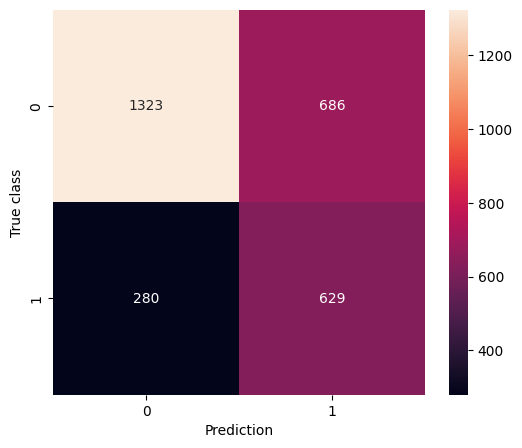

In [83]:
cm = confusion_matrix(message_val['burnout_t+3'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [84]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+3'])

classification_report(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.77      0.52      0.62      2009\n        True       0.38      0.66      0.49       909\n\n    accuracy                           0.56      2918\n   macro avg       0.58      0.59      0.55      2918\nweighted avg       0.65      0.56      0.58      2918\n'

Text(45.722222222222214, 0.5, 'True class')

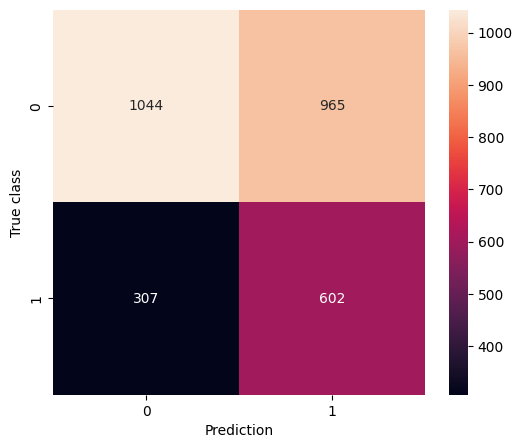

In [85]:
cm = confusion_matrix(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [86]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+3'])

classification_report(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.75      0.55      0.64      2009\n        True       0.37      0.59      0.46       909\n\n    accuracy                           0.56      2918\n   macro avg       0.56      0.57      0.55      2918\nweighted avg       0.63      0.56      0.58      2918\n'

Text(45.722222222222214, 0.5, 'True class')

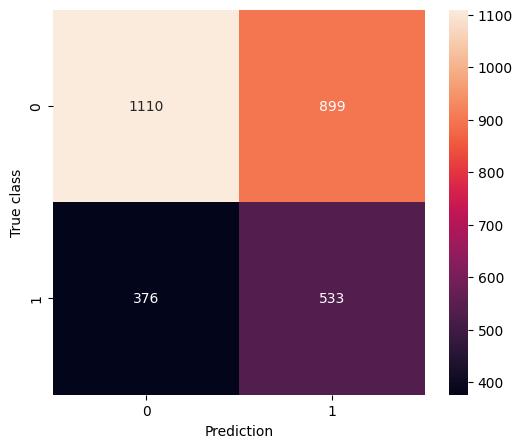

In [87]:
cm = confusion_matrix(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# RF models

In [88]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000), max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(train_tf, message_train['burnout_t+3'])

classification_report(message_val['burnout_t+3'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.79      0.87      0.83      2009\n        True       0.62      0.49      0.55       909\n\n    accuracy                           0.75      2918\n   macro avg       0.70      0.68      0.69      2918\nweighted avg       0.74      0.75      0.74      2918\n'

Text(45.722222222222214, 0.5, 'True class')

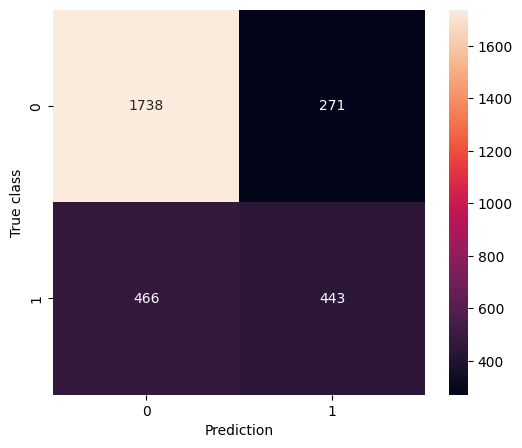

In [89]:
cm = confusion_matrix(message_val['burnout_t+3'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [90]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+3'])

classification_report(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.75      0.92      0.82      2009\n        True       0.63      0.31      0.42       909\n\n    accuracy                           0.73      2918\n   macro avg       0.69      0.62      0.62      2918\nweighted avg       0.71      0.73      0.70      2918\n'

Text(45.722222222222214, 0.5, 'True class')

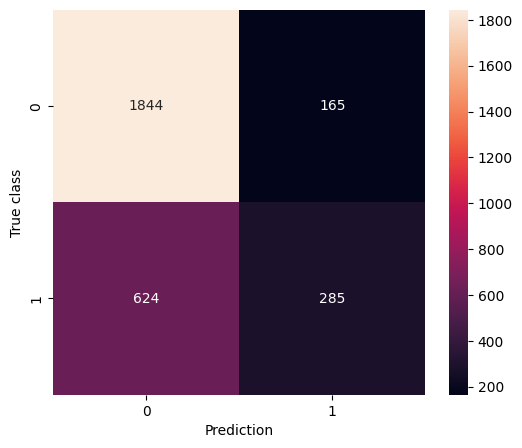

In [91]:
cm = confusion_matrix(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [92]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+3'])

classification_report(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.71      0.95      0.82      2009\n        True       0.59      0.15      0.24       909\n\n    accuracy                           0.70      2918\n   macro avg       0.65      0.55      0.53      2918\nweighted avg       0.68      0.70      0.64      2918\n'

Text(45.722222222222214, 0.5, 'True class')

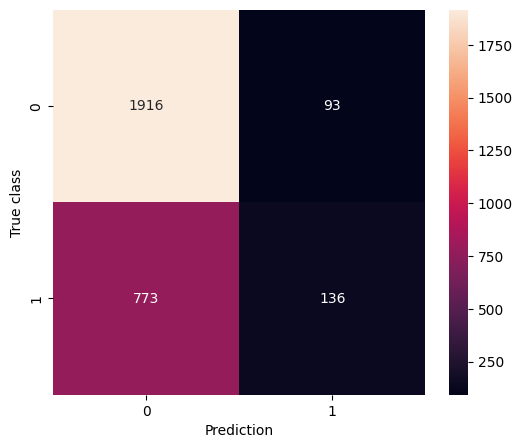

In [93]:
cm = confusion_matrix(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

## Burnout T+12

In [94]:
burnout_logistic_data = logistic_data[~logistic_data.burnout.isna()].drop(['burnout_t+1', 'burnout_t+3', 'burnout', 'ragequit_t+1', 'ragequit_t+3', 'ragequit_t+12', 'git_close'], axis = 1).drop_duplicates().drop(['Alias', 'From', 'To', 'start_datetime', 'end_datetime', 'lagged_burnout', 'reply_close', 'working_months', 'quit', 'first_quit_month', 'git_degree', 'Workload'], axis = 1).dropna().astype({'burnout_t+12':bool})
logistic_train_data, logistic_test_data = train_test_split(burnout_logistic_data, test_size = 0.2, random_state = 404, stratify = burnout_logistic_data['burnout_t+12'])

In [95]:
lr_model = LogisticRegressionCV(max_iter = 1000000).fit(logistic_train_data.drop('burnout_t+12', axis = 1), logistic_train_data['burnout_t+12'])

Text(45.722222222222214, 0.5, 'True class')

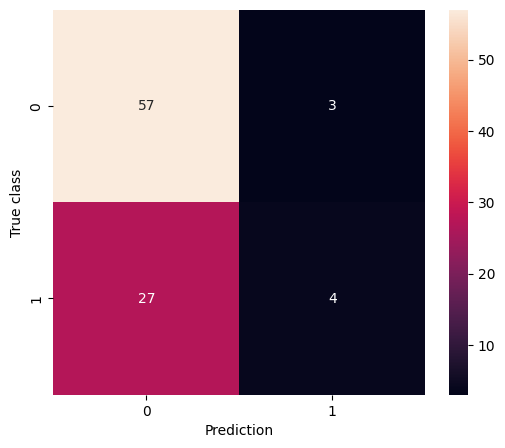

In [96]:
cm = confusion_matrix(logistic_test_data['burnout_t+12'], lr_model.predict(logistic_test_data.drop('burnout_t+12', axis = 1)))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

statsmodels

In [97]:
stat_model = sm.Logit(logistic_train_data['burnout_t+12'].astype(float), sm.add_constant(logistic_train_data.drop('burnout_t+12', axis = 1)).astype(float)).fit(disp = 0)
stat_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           burnout_t+12   No. Observations:                  364
Model:                          Logit   Df Residuals:                      350
Method:                           MLE   Df Model:                           13
Date:                Thu, 29 May 2025   Pseudo R-squ.:                 0.05516
Time:                        01:08:36   Log-Likelihood:                -221.84
converged:                       True   LL-Null:                       -234.79
Covariance Type:            nonrobust   LLR p-value:                   0.01751
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.2448      1.238     -0.198      0.843      -2.672       2.182
Avg. distance             0.1199      0.165      0.725      0.468      -0.204       0.444
Lone Wolf                 0.4614      0.435      1.061      0.289      -0.391       1.314
Messages Sent             0.0074      0.003      2.454      0.014       0.001       0.013
Organisational Silo      -0.2994      0.332     -0.901      0.367      -0.950       0.352
Radio Silence            -0.2817      0.267     -1.054      0.292      -0.806       0.242
standardized_workload     0.0086      0.036      0.240      0.810      -0.062       0.079
black_cloud              -0.0265      0.448     -0.059      0.953      -0.905       0.852
st_congruence            -0.5491      0.829     -0.662      0.508      -2.174       1.076
reply_degree             -3.8668      2.440     -1.585      0.113      -8.649       0.916
reply_between             0.3307      2.701      0.122      0.903      -4.963       5.624
git_between               1.6493      1.035      1.593      0.111      -0.380       3.678
reply_density            -1.0395      2.459     -0.423      0.673      -5.860       3.781
git_density               0.7081      0.816      0.868      0.386      -0.892       2.308
=========================================================================================
"""

Text(45.722222222222214, 0.5, 'True class')

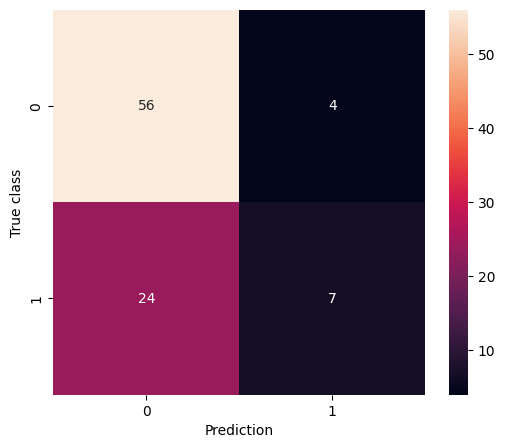

In [98]:
cm = confusion_matrix(logistic_test_data['burnout_t+12'], round(stat_model.predict(sm.add_constant(logistic_test_data.drop('burnout_t+12', axis = 1)).astype(float))).astype(int))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

### Burnout NB

In [99]:
message_data = all_test[['reply_body', 'burnout_t+12']].dropna()

nlp = spacy.load('en_core_web_sm')
tqdm.pandas()

message_data['lemmas'] = message_data.reply_body.progress_apply(lambda x: [token.lemma_ for token in nlp(handle_negation(x)) if not token.is_stop and token.is_alpha])
message_data['burnout_t+12'] = message_data['burnout_t+12'].astype(bool)
message_data

100%|██████████| 20241/20241 [05:06<00:00, 66.09it/s] 


,reply_body,burnout_t+12,lemmas
6,appliedcommitted,False,[appliedcommitte]
7,proxy server received an invalid response from...,False,"[proxy, server, receive, invalid, response, up..."
8,"we actually could use that, as we have a trad...",False,"[actually, use, trademark, asf, want, add, sur..."
10,my vote would be m5 so we out.,False,[vote]
11,that is the beautiful part of is not Positive...,False,"[beautiful, PositiveSentiment]"
...,...,...,...
22813,i should have all of the necessary paperwork s...,True,"[necessary, paperwork, email, let, know, join,..."
22814,"hi all, i was wondering - is it possible to ha...",True,"[hi, wonder, possible, plugin, need, example, ..."
22815,"sorry joe, i just got back to my am glad it ch...",True,"[sorry, joe, get, glad, change, change, cause,..."
22816,i think the subject is think about that ?,True,"[think, subject, think]"


In [100]:
message_data = message_data[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 0]

message_train, message_test = train_test_split(message_data, test_size=0.15, random_state=404, stratify = message_data['burnout_t+12'])
message_train, message_val = train_test_split(message_train, test_size=(0.15/0.85), random_state=404, stratify = message_train['burnout_t+12'])

print(f'length of train set: {len(message_train)}\nlength of validation set: {len(message_val)}\nlength of test set: {len(message_test)}')
message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages

# Oversample on the True cases in the train set
if 2*message_train["burnout_t+12"].sum()<len(message_train):
   # True is the minority class
    if 3*message_train["burnout_t+12"].sum()<len(message_train):
        # We need to over- and undersample to create balance
        message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+12"]==1].index], message_train])
        print(f'Positive cases: {message_train["burnout_t+12"].sum()}')

        if 3*message_train["burnout_t+12"].sum()<len(message_train):
            # Check for massive imbalance
            message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+12"]==1].index], message_train])
            print(f'Positive cases: {message_train["burnout_t+12"].sum()}')

        nMax = message_train["burnout_t+12"].sum()
        message_train = message_train.groupby("burnout_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')
    else:
        nMax = message_train["burnout_t+12"].sum()
        # Only undersampling will do
        print(f'Positive cases: {message_train["burnout_t+12"].sum()}')
        message_train = message_train.groupby("burnout_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')


else:
    if message_train["burnout_t+12"].sum()>0.67*len(message_train):
        # False is the minority class and we need to over- and undersample
        message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+12"]==0].index], message_train])
        print(f'Positive cases: {message_train["burnout_t+12"].sum()}')

        if message_train["burnout_t+12"].sum()>0.67*len(message_train):
            # Check for massive imbalance (mainly ragequit case)
            message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+12"]==0].index], message_train])
            print(f'Positive cases: {message_train["burnout_t+12"].sum()}')

        nMax = len(message_train) - message_train["burnout_t+12"].sum()
        message_train = message_train.groupby("burnout_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

    else:
        nMax = len(message_train) - message_train["burnout_t+12"].sum()
        print(f'Positive cases: {message_train["burnout_t+12"].sum()}')
        message_train = message_train.groupby("burnout_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

length of train set: 13617
length of validation set: 2918
length of test set: 2918
Positive cases: 4380
New length of train set: 8760


C:\Users\woute\AppData\Local\Temp\ipykernel_11104\188543492.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages
C:\Users\woute\AppData\Local\Temp\ipykernel_11104\188543492.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  message_train = message_train.groupby("burnout_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)


In [101]:
pos_labels, pos_values = zip(*Counter(itertools.chain(*message_data[message_data['burnout_t+12']].lemmas.tolist())).items())
neg_labels, neg_values = zip(*Counter(itertools.chain(*message_data[~message_data['burnout_t+12']].lemmas.tolist())).items())

importance_df = pd.DataFrame(index = list(set(pos_labels + neg_labels)), data = {'pos_occur': pd.Series(pos_values, index = pos_labels), 'neg_occur': pd.Series(neg_values, index = neg_labels)})
importance_df.fillna(0, inplace = True)
importance_df['total_appearances'] = importance_df['pos_occur'] + importance_df['neg_occur']

for i in range(0,125,25):
    p = i
    importance_df['pos_importance'] = (importance_df['pos_occur'] + p)/(importance_df['total_appearances']+2*p)
    importance_df['neg_importance'] = (importance_df['neg_occur'] + p)/(importance_df['total_appearances']+2*p)
    print(f'positive {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'pos_importance', ascending = False)[['pos_importance', 'pos_occur', 'total_appearances']].head(20))
    print(f'negative {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'neg_importance', ascending = False)[['neg_importance', 'neg_occur', 'total_appearances']].head(20))
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

positive 0:
           pos_importance  pos_occur  total_appearances
src              0.927407      626.0              675.0
jenck            0.855079     1894.0             2215.0
webapp           0.776371      184.0              237.0
adapter          0.773585       82.0              106.0
mbean            0.755981      158.0              209.0
standard         0.741450      542.0              731.0
trunk            0.727848      690.0              948.0
supply           0.726619      101.0              139.0
s                0.725806       90.0              124.0
ws               0.720721       80.0              111.0
engine           0.720339       85.0              118.0
david            0.692308      387.0              559.0
part             0.686567       92.0              134.0
construct        0.679803      138.0              203.0
builder          0.674888      301.0              446.0
warn             0.672000       84.0              125.0
xmlbean          0.669355       83.0

In [102]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000), max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = MultinomialNB()
classifier.fit(train_tf, message_train['burnout_t+12'])

classification_report(message_val['burnout_t+12'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.78      0.65      0.71      1753\n        True       0.58      0.73      0.64      1165\n\n    accuracy                           0.68      2918\n   macro avg       0.68      0.69      0.68      2918\nweighted avg       0.70      0.68      0.68      2918\n'

Text(45.722222222222214, 0.5, 'True class')

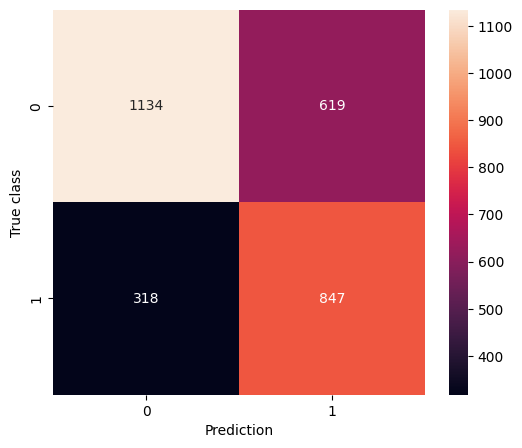

In [103]:
cm = confusion_matrix(message_val['burnout_t+12'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [104]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+12'])

classification_report(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.67      0.51      0.58      1753\n        True       0.46      0.63      0.53      1165\n\n    accuracy                           0.55      2918\n   macro avg       0.56      0.57      0.55      2918\nweighted avg       0.59      0.55      0.56      2918\n'

Text(45.722222222222214, 0.5, 'True class')

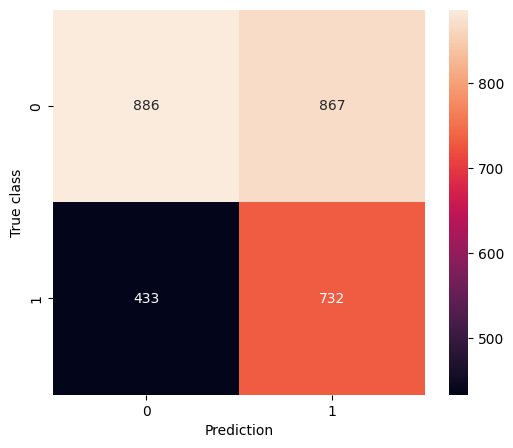

In [105]:
cm = confusion_matrix(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [106]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+12'])

classification_report(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.67      0.58      0.62      1753\n        True       0.47      0.57      0.52      1165\n\n    accuracy                           0.57      2918\n   macro avg       0.57      0.57      0.57      2918\nweighted avg       0.59      0.57      0.58      2918\n'

Text(45.722222222222214, 0.5, 'True class')

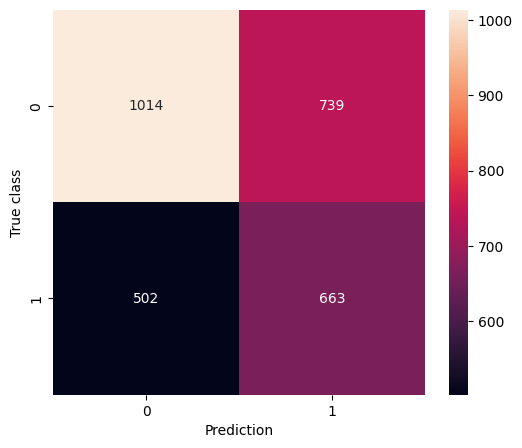

In [107]:
cm = confusion_matrix(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# RF models

In [108]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000), max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(train_tf, message_train['burnout_t+12'])

classification_report(message_val['burnout_t+12'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.76      0.77      0.77      1753\n        True       0.65      0.64      0.65      1165\n\n    accuracy                           0.72      2918\n   macro avg       0.71      0.71      0.71      2918\nweighted avg       0.72      0.72      0.72      2918\n'

Text(45.722222222222214, 0.5, 'True class')

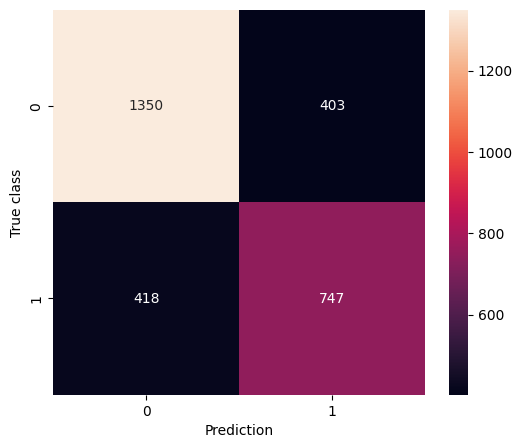

In [109]:
cm = confusion_matrix(message_val['burnout_t+12'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [110]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+12'])

classification_report(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.72      0.64      0.67      1753\n        True       0.53      0.62      0.57      1165\n\n    accuracy                           0.63      2918\n   macro avg       0.62      0.63      0.62      2918\nweighted avg       0.64      0.63      0.63      2918\n'

Text(45.722222222222214, 0.5, 'True class')

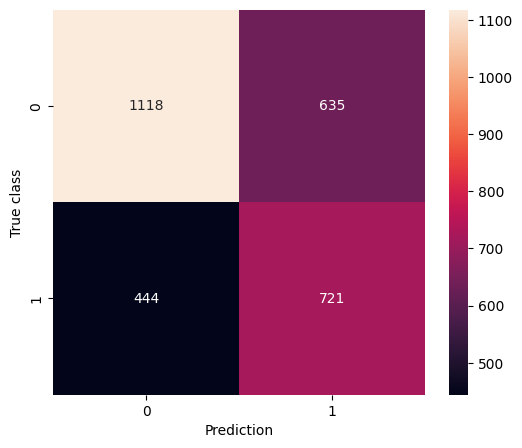

In [111]:
cm = confusion_matrix(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [112]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+12'])

classification_report(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.68      0.58      0.63      1753\n        True       0.48      0.59      0.53      1165\n\n    accuracy                           0.58      2918\n   macro avg       0.58      0.58      0.58      2918\nweighted avg       0.60      0.58      0.59      2918\n'

Text(45.722222222222214, 0.5, 'True class')

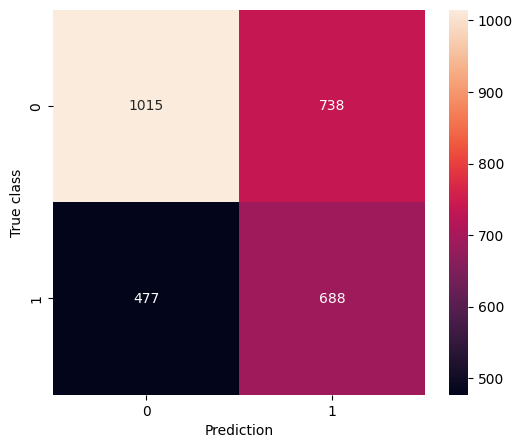

In [113]:
cm = confusion_matrix(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

## Ragequit T+3

In [114]:
burnout_logistic_data = logistic_data[~logistic_data.burnout.isna()].drop(['burnout_t+1', 'burnout_t+3', 'burnout_t+12', 'ragequit_t+1', 'burnout', 'ragequit_t+12', 'git_close'], axis = 1).drop_duplicates().drop(['Alias', 'From', 'To', 'start_datetime', 'end_datetime', 'lagged_burnout', 'reply_close', 'working_months', 'quit', 'first_quit_month', 'Workload'], axis = 1).dropna().astype({'ragequit_t+3':bool})
logistic_train_data, logistic_test_data = train_test_split(burnout_logistic_data, test_size = 0.2, random_state = 404, stratify = burnout_logistic_data['ragequit_t+3'])

In [115]:
lr_model = LogisticRegressionCV(max_iter = 1000000).fit(logistic_train_data.drop('ragequit_t+3', axis = 1), logistic_train_data['ragequit_t+3'])

Text(45.722222222222214, 0.5, 'True class')

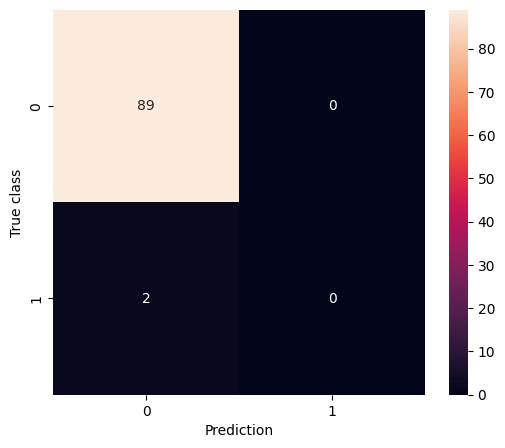

In [116]:
cm = confusion_matrix(logistic_test_data['ragequit_t+3'], lr_model.predict(logistic_test_data.drop('ragequit_t+3', axis = 1)))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

statsmodels

In [118]:
stat_model = sm.Logit(logistic_train_data['ragequit_t+3'].astype(float), sm.add_constant(logistic_train_data[['Avg. distance', 'Lone Wolf', 'standardized_workload',
 'Organisational Silo', 'Radio Silence',  'black_cloud', 'Messages Sent']]).astype(float)).fit(disp = 0)
stat_model.summary()

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           ragequit_t+3   No. Observations:                  364
Model:                          Logit   Df Residuals:                      356
Method:                           MLE   Df Model:                            7
Date:                Thu, 29 May 2025   Pseudo R-squ.:                  0.1347
Time:                        01:19:35   Log-Likelihood:                -33.273
converged:                      False   LL-Null:                       -38.453
Covariance Type:            nonrobust   LLR p-value:                    0.1691
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -3.1506      1.009     -3.123      0.002      -5.128      -1.173
Avg. distance             0.5451      0.476      1.145      0.252      -0.388       1.478
Lone Wolf               -17.2915   2285.670     -0.008      0.994   -4497.123    4462.540
standardized_workload    -0.3442      0.521     -0.660      0.509      -1.366       0.678
Organisational Silo      16.1978   2285.670      0.007      0.994   -4463.633    4496.029
Radio Silence            -1.3887      1.127     -1.232      0.218      -3.598       0.821
black_cloud               1.1311      1.499      0.755      0.450      -1.806       4.068
Messages Sent            -0.0114      0.016     -0.722      0.471      -0.042       0.020
=========================================================================================

Possibly complete quasi-separation: A fraction 0.24 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Text(45.722222222222214, 0.5, 'True class')

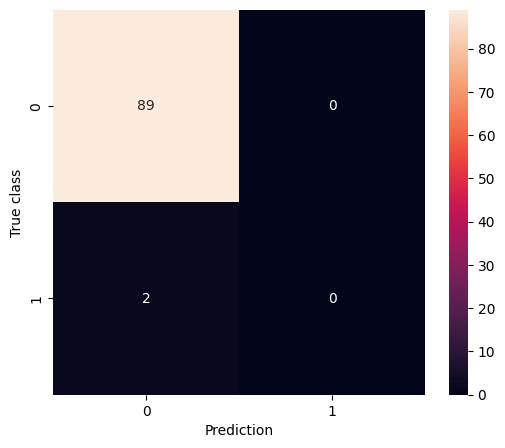

In [121]:
cm = confusion_matrix(logistic_test_data['ragequit_t+3'], round(stat_model.predict(sm.add_constant(logistic_test_data[['Avg. distance', 'Lone Wolf', 'standardized_workload',
 'Organisational Silo', 'Radio Silence',  'black_cloud', 'Messages Sent']]).astype(float))).astype(int))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

### Burnout NB

In [120]:
message_data = all_test[['reply_body', 'ragequit_t+3']].dropna()

nlp = spacy.load('en_core_web_sm')
tqdm.pandas()

message_data['lemmas'] = message_data.reply_body.progress_apply(lambda x: [token.lemma_ for token in nlp(handle_negation(x)) if not token.is_stop and token.is_alpha])
message_data['ragequit_t+3'] = message_data['ragequit_t+3'].astype(bool)
message_data

100%|██████████| 20241/20241 [04:22<00:00, 77.09it/s] 


,reply_body,ragequit_t+3,lemmas
6,appliedcommitted,False,[appliedcommitte]
7,proxy server received an invalid response from...,False,"[proxy, server, receive, invalid, response, up..."
8,"we actually could use that, as we have a trad...",False,"[actually, use, trademark, asf, want, add, sur..."
10,my vote would be m5 so we out.,False,[vote]
11,that is the beautiful part of is not Positive...,False,"[beautiful, PositiveSentiment]"
...,...,...,...
22813,i should have all of the necessary paperwork s...,False,"[necessary, paperwork, email, let, know, join,..."
22814,"hi all, i was wondering - is it possible to ha...",False,"[hi, wonder, possible, plugin, need, example, ..."
22815,"sorry joe, i just got back to my am glad it ch...",False,"[sorry, joe, get, glad, change, change, cause,..."
22816,i think the subject is think about that ?,False,"[think, subject, think]"


In [122]:
message_data = message_data[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 0]

message_train, message_test = train_test_split(message_data, test_size=0.15, random_state=404, stratify = message_data['ragequit_t+3'])
message_train, message_val = train_test_split(message_train, test_size=(0.15/0.85), random_state=404, stratify = message_train['ragequit_t+3'])

print(f'length of train set: {len(message_train)}\nlength of validation set: {len(message_val)}\nlength of test set: {len(message_test)}')
message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages

# Oversample on the True cases in the train set
if 2*message_train["ragequit_t+3"].sum()<len(message_train):
   # True is the minority class
    if 3*message_train["ragequit_t+3"].sum()<len(message_train):
        # We need to over- and undersample to create balance
        message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+3"]==1].index], message_train])
        print(f'Positive cases: {message_train["ragequit_t+3"].sum()}')

        if 3*message_train["ragequit_t+3"].sum()<len(message_train):
            # Check for massive imbalance
            message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+3"]==1].index], message_train])
            print(f'Positive cases: {message_train["ragequit_t+3"].sum()}')

        nMax = message_train["ragequit_t+3"].sum()
        message_train = message_train.groupby("ragequit_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')
    else:
        nMax = message_train["ragequit_t+3"].sum()
        # Only undersampling will do
        print(f'Positive cases: {message_train["ragequit_t+3"].sum()}')
        message_train = message_train.groupby("ragequit_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')


else:
    if message_train["ragequit_t+3"].sum()>0.67*len(message_train):
        # False is the minority class and we need to over- and undersample
        message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+3"]==0].index], message_train])
        print(f'Positive cases: {message_train["ragequit_t+3"].sum()}')

        if message_train["ragequit_t+3"].sum()>0.67*len(message_train):
            # Check for massive imbalance (mainly ragequit case)
            message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+3"]==0].index], message_train])
            print(f'Positive cases: {message_train["ragequit_t+3"].sum()}')

        nMax = len(message_train) - message_train["ragequit_t+3"].sum()
        message_train = message_train.groupby("ragequit_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

    else:
        nMax = len(message_train) - message_train["ragequit_t+3"].sum()
        print(f'Positive cases: {message_train["ragequit_t+3"].sum()}')
        message_train = message_train.groupby("ragequit_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

length of train set: 13617
length of validation set: 2918
length of test set: 2918
Positive cases: 782
Positive cases: 2346
New length of train set: 4692


C:\Users\woute\AppData\Local\Temp\ipykernel_11104\3232222597.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages
C:\Users\woute\AppData\Local\Temp\ipykernel_11104\3232222597.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  message_train = message_train.groupby("ragequit_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)


In [123]:
pos_labels, pos_values = zip(*Counter(itertools.chain(*message_data[message_data['ragequit_t+3']].lemmas.tolist())).items())
neg_labels, neg_values = zip(*Counter(itertools.chain(*message_data[~message_data['ragequit_t+3']].lemmas.tolist())).items())

importance_df = pd.DataFrame(index = list(set(pos_labels + neg_labels)), data = {'pos_occur': pd.Series(pos_values, index = pos_labels), 'neg_occur': pd.Series(neg_values, index = neg_labels)})
importance_df.fillna(0, inplace = True)
importance_df['total_appearances'] = importance_df['pos_occur'] + importance_df['neg_occur']

for i in range(0,125,25):
    p = i
    importance_df['pos_importance'] = (importance_df['pos_occur'] + p)/(importance_df['total_appearances']+2*p)
    importance_df['neg_importance'] = (importance_df['neg_occur'] + p)/(importance_df['total_appearances']+2*p)
    print(f'positive {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'pos_importance', ascending = False)[['pos_importance', 'pos_occur', 'total_appearances']].head(20))
    print(f'negative {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'neg_importance', ascending = False)[['neg_importance', 'neg_occur', 'total_appearances']].head(20))
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

positive 0:
                     pos_importance  pos_occur  total_appearances
checkingtask               1.000000      167.0              167.0
deploymentplan             1.000000      475.0              475.0
deploygeronimombean        1.000000      163.0              163.0
startmbeaninstance         1.000000      107.0              107.0
band                       0.981132      104.0              106.0
geronimombean              0.948454      184.0              194.0
trace                      0.849807      662.0              779.0
perl                       0.768025      245.0              319.0
true                       0.680000      170.0              250.0
f                          0.661157       80.0              121.0
task                       0.658849      309.0              469.0
role                       0.602837      255.0              423.0
print                      0.591255      311.0              526.0
castor                     0.577413      317.0              549.

In [124]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000), max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = MultinomialNB()
classifier.fit(train_tf, message_train['ragequit_t+3'])

classification_report(message_val['ragequit_t+3'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.99      0.89      0.94      2821\n        True       0.18      0.66      0.28        97\n\n    accuracy                           0.89      2918\n   macro avg       0.58      0.78      0.61      2918\nweighted avg       0.96      0.89      0.92      2918\n'

Text(45.722222222222214, 0.5, 'True class')

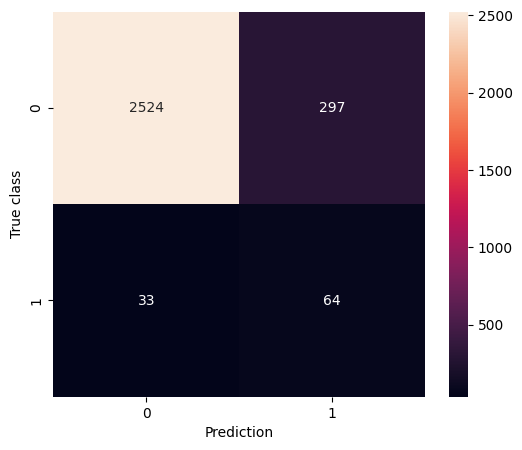

In [125]:
cm = confusion_matrix(message_val['ragequit_t+3'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [126]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+3'])

classification_report(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.98      0.95      0.96      2821\n        True       0.24      0.49      0.32        97\n\n    accuracy                           0.93      2918\n   macro avg       0.61      0.72      0.64      2918\nweighted avg       0.96      0.93      0.94      2918\n'

Text(45.722222222222214, 0.5, 'True class')

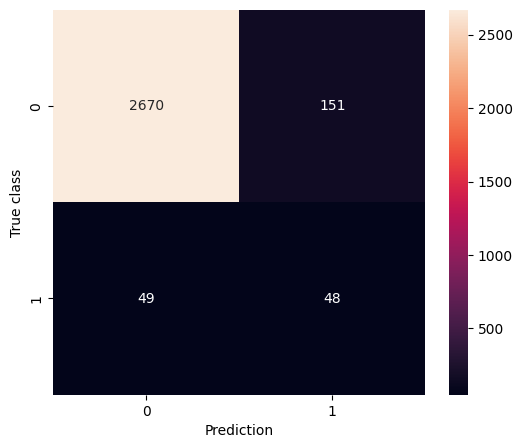

In [127]:
cm = confusion_matrix(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [128]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+3'])

classification_report(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.98      0.67      0.80      2821\n        True       0.07      0.67      0.12        97\n\n    accuracy                           0.67      2918\n   macro avg       0.52      0.67      0.46      2918\nweighted avg       0.95      0.67      0.78      2918\n'

Text(45.722222222222214, 0.5, 'True class')

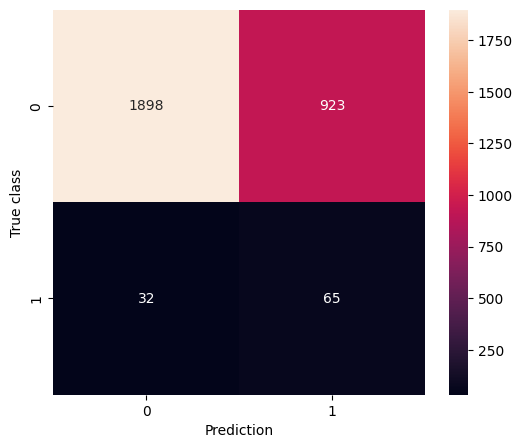

In [129]:
cm = confusion_matrix(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# RF models

In [130]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000), max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(train_tf, message_train['ragequit_t+3'])

classification_report(message_val['ragequit_t+3'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.99      0.98      0.99      2821\n        True       0.60      0.66      0.63        97\n\n    accuracy                           0.97      2918\n   macro avg       0.79      0.82      0.81      2918\nweighted avg       0.98      0.97      0.97      2918\n'

Text(45.722222222222214, 0.5, 'True class')

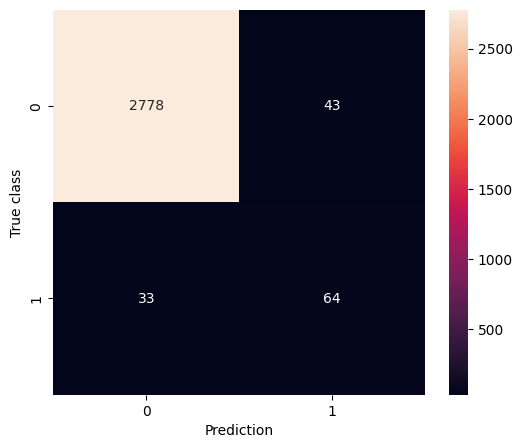

In [131]:
cm = confusion_matrix(message_val['ragequit_t+3'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [132]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+3'])

classification_report(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.98      0.99      0.98      2821\n        True       0.54      0.45      0.49        97\n\n    accuracy                           0.97      2918\n   macro avg       0.76      0.72      0.74      2918\nweighted avg       0.97      0.97      0.97      2918\n'

Text(45.722222222222214, 0.5, 'True class')

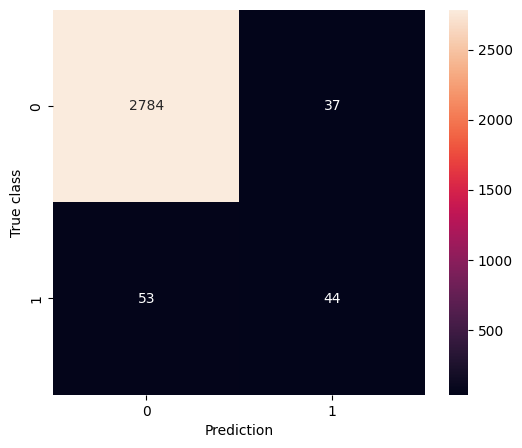

In [133]:
cm = confusion_matrix(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [134]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+3'])

classification_report(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.98      0.99      0.98      2821\n        True       0.56      0.38      0.45        97\n\n    accuracy                           0.97      2918\n   macro avg       0.77      0.69      0.72      2918\nweighted avg       0.97      0.97      0.97      2918\n'

Text(45.722222222222214, 0.5, 'True class')

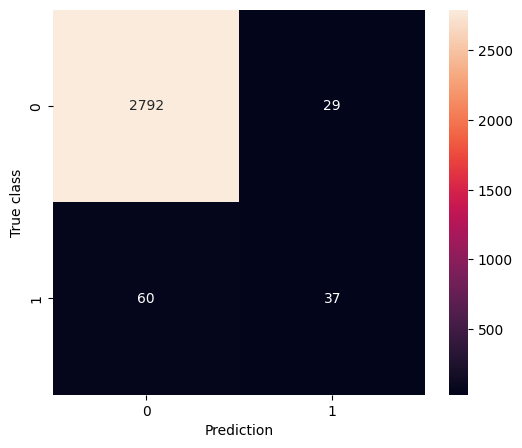

In [135]:
cm = confusion_matrix(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

## Ragequit T+12

In [136]:
burnout_logistic_data = logistic_data[~logistic_data.burnout.isna()].drop(['burnout_t+1', 'burnout_t+3', 'burnout_t+12', 'ragequit_t+1', 'ragequit_t+3', 'burnout', 'git_close'], axis = 1).drop_duplicates().drop(['Alias', 'From', 'To', 'start_datetime', 'end_datetime', 'lagged_burnout', 'reply_close', 'working_months', 'quit', 'first_quit_month', 'git_degree', 'Workload'], axis = 1).dropna().astype({'ragequit_t+12':bool})
logistic_train_data, logistic_test_data = train_test_split(burnout_logistic_data, test_size = 0.2, random_state = 404, stratify = burnout_logistic_data['ragequit_t+12'])

In [137]:
lr_model = LogisticRegressionCV(max_iter = 1000000).fit(logistic_train_data.drop('ragequit_t+12', axis = 1), logistic_train_data['ragequit_t+12'])

Text(45.722222222222214, 0.5, 'True class')

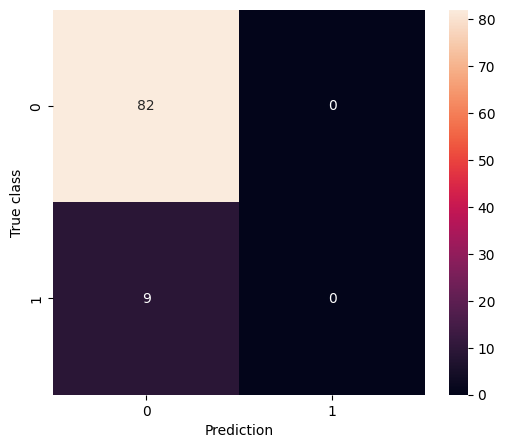

In [138]:
cm = confusion_matrix(logistic_test_data['ragequit_t+12'], lr_model.predict(logistic_test_data.drop('ragequit_t+12', axis = 1)))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

statsmodels

In [139]:
stat_model = sm.Logit(logistic_train_data['ragequit_t+12'].astype(float), sm.add_constant(logistic_train_data.drop('ragequit_t+12', axis = 1)).astype(float)).fit(disp = 0)
stat_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          ragequit_t+12   No. Observations:                  364
Model:                          Logit   Df Residuals:                      350
Method:                           MLE   Df Model:                           13
Date:                Thu, 29 May 2025   Pseudo R-squ.:                 0.03400
Time:                        01:26:50   Log-Likelihood:                -113.46
converged:                       True   LL-Null:                       -117.45
Covariance Type:            nonrobust   LLR p-value:                    0.8444
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.5912      1.710     -0.930      0.352      -4.944       1.761
Avg. distance             0.2102      0.206      1.020      0.308      -0.194       0.614
Lone Wolf                -0.3533      0.620     -0.570      0.569      -1.568       0.861
Messages Sent            -0.0059      0.007     -0.869      0.385      -0.019       0.007
Organisational Silo      -0.2807      0.512     -0.548      0.583      -1.284       0.723
Radio Silence             0.1590      0.416      0.383      0.702      -0.656       0.974
standardized_workload    -0.1321      0.149     -0.889      0.374      -0.423       0.159
black_cloud              -0.2760      0.664     -0.416      0.678      -1.578       1.026
st_congruence            -0.3060      1.257     -0.243      0.808      -2.769       2.157
reply_degree             -0.3508      3.378     -0.104      0.917      -6.972       6.271
reply_between             1.7827      4.040      0.441      0.659      -6.135       9.700
git_between               0.3550      1.466      0.242      0.809      -2.519       3.229
reply_density            -0.4862      3.839     -0.127      0.899      -8.011       7.039
git_density              -0.7370      1.273     -0.579      0.563      -3.233       1.759
=========================================================================================
"""

Text(45.722222222222214, 0.5, 'True class')

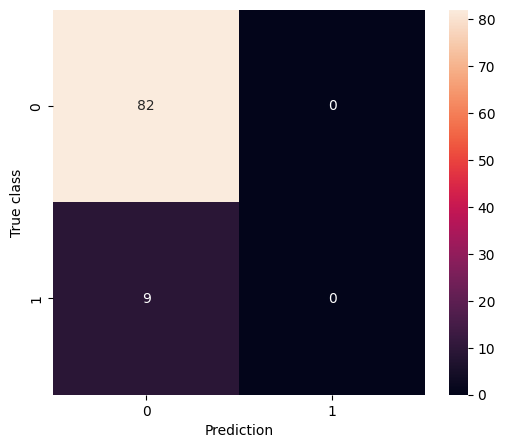

In [140]:
cm = confusion_matrix(logistic_test_data['ragequit_t+12'], round(stat_model.predict(sm.add_constant(logistic_test_data.drop('ragequit_t+12', axis = 1)).astype(float))).astype(int))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

### Burnout NB

In [141]:
message_data = all_test[['reply_body', 'ragequit_t+12']].dropna()

nlp = spacy.load('en_core_web_sm')
tqdm.pandas()

message_data['lemmas'] = message_data.reply_body.progress_apply(lambda x: [token.lemma_ for token in nlp(handle_negation(x)) if not token.is_stop and token.is_alpha])
message_data['ragequit_t+12'] = message_data['ragequit_t+12'].astype(bool)
message_data

100%|██████████| 20241/20241 [04:28<00:00, 75.34it/s] 


,reply_body,ragequit_t+12,lemmas
6,appliedcommitted,False,[appliedcommitte]
7,proxy server received an invalid response from...,False,"[proxy, server, receive, invalid, response, up..."
8,"we actually could use that, as we have a trad...",False,"[actually, use, trademark, asf, want, add, sur..."
10,my vote would be m5 so we out.,False,[vote]
11,that is the beautiful part of is not Positive...,False,"[beautiful, PositiveSentiment]"
...,...,...,...
22813,i should have all of the necessary paperwork s...,False,"[necessary, paperwork, email, let, know, join,..."
22814,"hi all, i was wondering - is it possible to ha...",False,"[hi, wonder, possible, plugin, need, example, ..."
22815,"sorry joe, i just got back to my am glad it ch...",False,"[sorry, joe, get, glad, change, change, cause,..."
22816,i think the subject is think about that ?,False,"[think, subject, think]"


In [142]:
message_data = message_data[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 0]

message_train, message_test = train_test_split(message_data, test_size=0.15, random_state=404, stratify = message_data['ragequit_t+12'])
message_train, message_val = train_test_split(message_train, test_size=(0.15/0.85), random_state=404, stratify = message_train['ragequit_t+12'])

print(f'length of train set: {len(message_train)}\nlength of validation set: {len(message_val)}\nlength of test set: {len(message_test)}')
message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages

# Oversample on the True cases in the train set
if 2*message_train["ragequit_t+12"].sum()<len(message_train):
   # True is the minority class
    if 3*message_train["ragequit_t+12"].sum()<len(message_train):
        # We need to over- and undersample to create balance
        message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+12"]==1].index], message_train])
        print(f'Positive cases: {message_train["ragequit_t+12"].sum()}')

        if 3*message_train["ragequit_t+12"].sum()<len(message_train):
            # Check for massive imbalance
            message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+12"]==1].index], message_train])
            print(f'Positive cases: {message_train["ragequit_t+12"].sum()}')

        nMax = message_train["ragequit_t+12"].sum()
        message_train = message_train.groupby("ragequit_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')
    else:
        nMax = message_train["ragequit_t+12"].sum()
        # Only undersampling will do
        print(f'Positive cases: {message_train["ragequit_t+12"].sum()}')
        message_train = message_train.groupby("ragequit_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')


else:
    if message_train["ragequit_t+12"].sum()>0.67*len(message_train):
        # False is the minority class and we need to over- and undersample
        message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+12"]==0].index], message_train])
        print(f'Positive cases: {message_train["ragequit_t+12"].sum()}')

        if message_train["ragequit_t+12"].sum()>0.67*len(message_train):
            # Check for massive imbalance (mainly ragequit case)
            message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+12"]==0].index], message_train])
            print(f'Positive cases: {message_train["ragequit_t+12"].sum()}')

        nMax = len(message_train) - message_train["ragequit_t+12"].sum()
        message_train = message_train.groupby("ragequit_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

    else:
        nMax = len(message_train) - message_train["ragequit_t+12"].sum()
        print(f'Positive cases: {message_train["ragequit_t+12"].sum()}')
        message_train = message_train.groupby("ragequit_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

length of train set: 13617
length of validation set: 2918
length of test set: 2918
Positive cases: 3184
Positive cases: 9552
New length of train set: 18868


C:\Users\woute\AppData\Local\Temp\ipykernel_11104\2668262174.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages
C:\Users\woute\AppData\Local\Temp\ipykernel_11104\2668262174.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  message_train = message_train.groupby("ragequit_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)


In [143]:
pos_labels, pos_values = zip(*Counter(itertools.chain(*message_data[message_data['ragequit_t+12']].lemmas.tolist())).items())
neg_labels, neg_values = zip(*Counter(itertools.chain(*message_data[~message_data['ragequit_t+12']].lemmas.tolist())).items())

importance_df = pd.DataFrame(index = list(set(pos_labels + neg_labels)), data = {'pos_occur': pd.Series(pos_values, index = pos_labels), 'neg_occur': pd.Series(neg_values, index = neg_labels)})
importance_df.fillna(0, inplace = True)
importance_df['total_appearances'] = importance_df['pos_occur'] + importance_df['neg_occur']

for i in range(0,125,25):
    p = i
    importance_df['pos_importance'] = (importance_df['pos_occur'] + p)/(importance_df['total_appearances']+2*p)
    importance_df['neg_importance'] = (importance_df['neg_occur'] + p)/(importance_df['total_appearances']+2*p)
    print(f'positive {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'pos_importance', ascending = False)[['pos_importance', 'pos_occur', 'total_appearances']].head(20))
    print(f'negative {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'neg_importance', ascending = False)[['neg_importance', 'neg_occur', 'total_appearances']].head(20))
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

positive 0:
                     pos_importance  pos_occur  total_appearances
band                       1.000000      106.0              106.0
startmbeaninstance         1.000000      107.0              107.0
deploymentplan             1.000000      475.0              475.0
deploygeronimombean        1.000000      163.0              163.0
checkingtask               1.000000      167.0              167.0
geronimombean              0.948454      184.0              194.0
f                          0.942149      114.0              121.0
print                      0.927757      488.0              526.0
castor                     0.923497      507.0              549.0
perl                       0.868339      277.0              319.0
trace                      0.865212      674.0              779.0
unpack                     0.805556      116.0              144.0
task                       0.750533      352.0              469.0
true                       0.720000      180.0              250.

In [144]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000), max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = MultinomialNB()
classifier.fit(train_tf, message_train['ragequit_t+12'])

classification_report(message_val['ragequit_t+12'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.92      0.79      0.85      2486\n        True       0.34      0.60      0.43       432\n\n    accuracy                           0.76      2918\n   macro avg       0.63      0.70      0.64      2918\nweighted avg       0.83      0.76      0.79      2918\n'

Text(45.722222222222214, 0.5, 'True class')

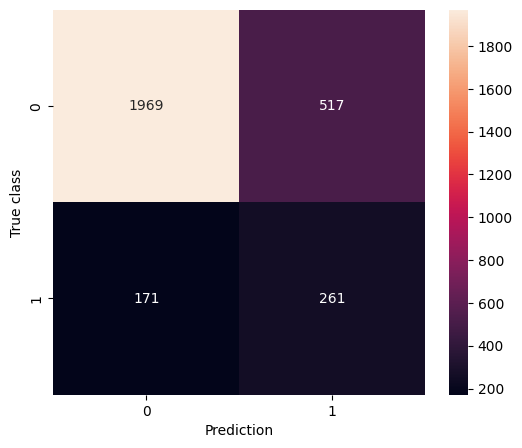

In [145]:
cm = confusion_matrix(message_val['ragequit_t+12'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [146]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+12'])

classification_report(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.88      0.74      0.80      2486\n        True       0.22      0.43      0.29       432\n\n    accuracy                           0.69      2918\n   macro avg       0.55      0.58      0.55      2918\nweighted avg       0.78      0.69      0.73      2918\n'

Text(45.722222222222214, 0.5, 'True class')

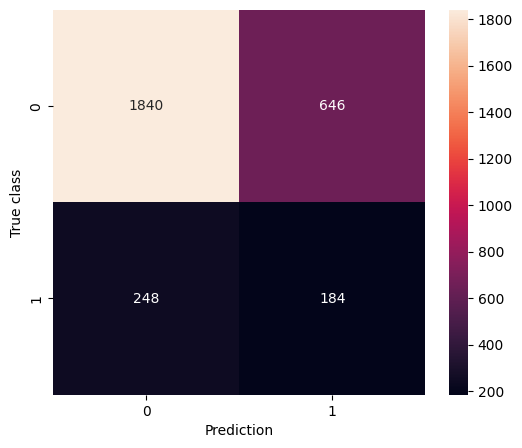

In [147]:
cm = confusion_matrix(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [148]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+12'])

classification_report(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.88      0.63      0.73      2486\n        True       0.19      0.50      0.28       432\n\n    accuracy                           0.61      2918\n   macro avg       0.54      0.57      0.51      2918\nweighted avg       0.78      0.61      0.67      2918\n'

Text(45.722222222222214, 0.5, 'True class')

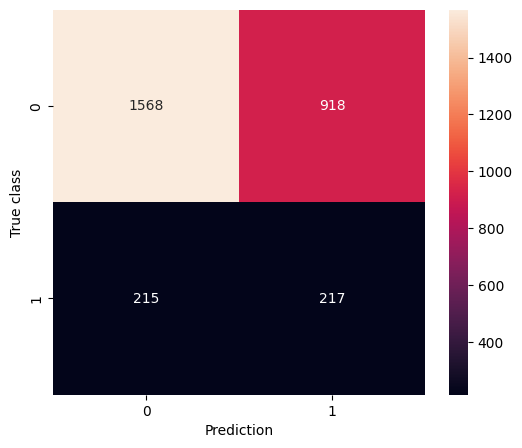

In [149]:
cm = confusion_matrix(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# RF models

In [150]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000), max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(train_tf, message_train['ragequit_t+12'])

classification_report(message_val['ragequit_t+12'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.89      0.98      0.93      2486\n        True       0.71      0.30      0.42       432\n\n    accuracy                           0.88      2918\n   macro avg       0.80      0.64      0.68      2918\nweighted avg       0.86      0.88      0.86      2918\n'

Text(45.722222222222214, 0.5, 'True class')

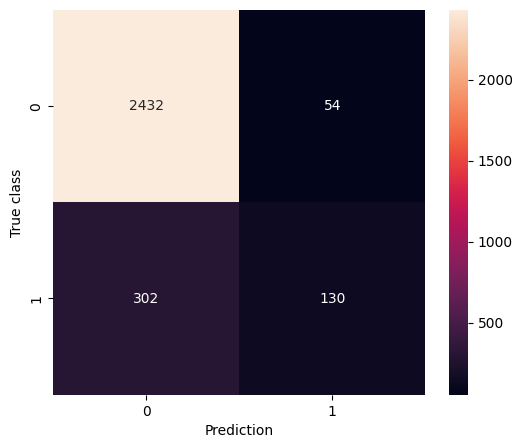

In [151]:
cm = confusion_matrix(message_val['ragequit_t+12'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [152]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+12'])

classification_report(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.87      1.00      0.93      2486\n        True       0.87      0.16      0.26       432\n\n    accuracy                           0.87      2918\n   macro avg       0.87      0.58      0.60      2918\nweighted avg       0.87      0.87      0.83      2918\n'

Text(45.722222222222214, 0.5, 'True class')

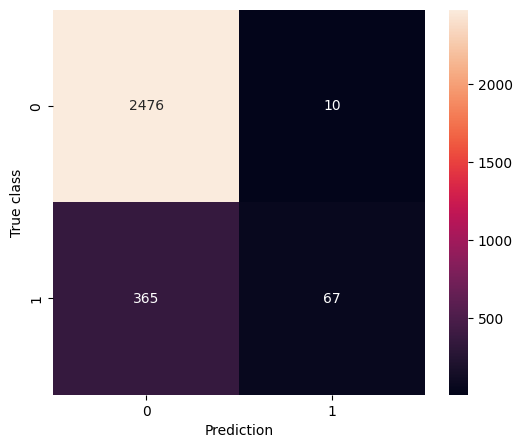

In [153]:
cm = confusion_matrix(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [154]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+12'])

classification_report(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.87      1.00      0.93      2486\n        True       0.96      0.11      0.20       432\n\n    accuracy                           0.87      2918\n   macro avg       0.91      0.56      0.57      2918\nweighted avg       0.88      0.87      0.82      2918\n'

Text(45.722222222222214, 0.5, 'True class')

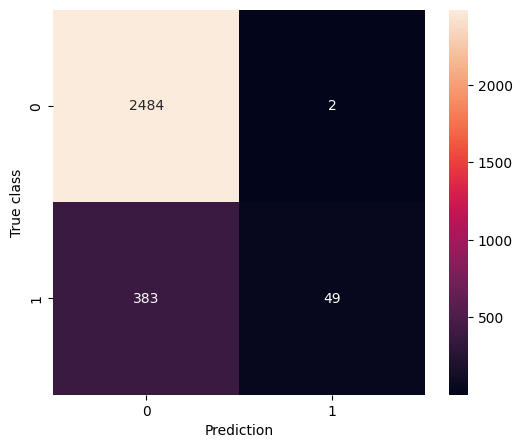

In [155]:
cm = confusion_matrix(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')